## Gaussian Puff Model

Yunha Lee 
August 7, 2024


# Pre-Step: Get weather data for the target area and times

In [ ]:

##TODO GET_STABILITY_CLASS MUST TAKE SURFACE_WIND, not the U_Wind!! 

import pandas as pd
import xarray as xr

# Define the path and variables
weather_file_names = ['u_wind', 'v_wind', 'wind_direction', 'vertical_velocity', 'temperature']
data_dir = "/Users/yunhalee/Documents/methanDart/UCAR_reanalysis/"
geopotential_file = f"{data_dir}geopotential_height_NorthAmerica.nc"

# Define source locations and time range
source_locs = pd.DataFrame({
    'lat': [34.05, 34.06],
    'lon': [-118.25, -118.26],
    'height': [10, 50]  # Heights in meters
})
start_time = pd.to_datetime("2015-06-01 12:00:00")
end_time = pd.to_datetime("2015-06-10 12:00:00")

# Read geopotential height to find the corresponding pressure levels
with xr.open_dataset(geopotential_file) as ds:
    ds_gph = ds.sel(time=slice(start_time, end_time))

    # Dictionary to hold DataFrames for each location
    location_weather_data = {}

    # Iterate over each location
    for index, row in source_locs.iterrows():
        loc_id = f"lat{row['lat']}_lon{row['lon']}_height{row['height']}"
        loc_weather_data = pd.DataFrame()

        # Iterate over each weather variable
        for var_name in weather_file_names:
            with xr.open_dataset(f"{data_dir}{var_name}_NorthAmerica.nc") as ds_var:
                ds_var = ds_var.sel(time=slice(start_time, end_time))

                # Get the nearest geopotential heights for this location and convert heights to pressure levels
                gph_values = ds_gph.sel(latitude=row['lat'], longitude=row['lon'], method='nearest')

                # Print dimensions to debug
                print("Dimensions of gph_values:", gph_values.dims)

                if 'time' in gph_values.dims:
                    gph_values = gph_values.isel(time=0)  # selecting the first time point for simplicity

                # Continue with height comparison
                height_diff = abs(gph_values['geopotential_height'] - row['height'])
                nearest_pressure_level_idx = height_diff.argmin(dim='isobaricInhPa')
                nearest_pressure_level = gph_values['isobaricInhPa'].isel(isobaricInhPa=nearest_pressure_level_idx).values

                print("Type of nearest_pressure_level:", type(nearest_pressure_level))
                print("Value of nearest_pressure_level:", nearest_pressure_level)


                var_data = ds_var.sel(latitude=row['lat'], longitude=row['lon'], isobaricInhPa=nearest_pressure_level, method='nearest')
                df_var = var_data.to_dataframe()

                # Renaming columns to reflect data specifics
                new_column_names = {
                    name: f"{name}"
                    for name in df_var.columns
                }

                df_var.rename(columns=new_column_names, inplace=True)
                if loc_weather_data.empty:
                    loc_weather_data = df_var
                else:
                    loc_weather_data = pd.merge(loc_weather_data, df_var, how='outer', left_index=True, right_index=True, suffixes=('', '_duplicate'))
                    duplicate_columns = [col for col in loc_weather_data.columns if '_duplicate' in col]
                    loc_weather_data.drop(columns=duplicate_columns, inplace=True)

        location_weather_data[loc_id] = loc_weather_data

        loc_weather_data.to_csv(f"../input_data/{loc_id}_weather_data.csv")

for loc_id, df in location_weather_data.items():
    print(f"Data for {loc_id}:")
    print(df.head())


## Run the GPM model

The end time of the simulation will be: 2015-06-01 13:00:00
DatetimeIndex(['2015-06-01 12:00:00', '2015-06-01 12:00:01',
               '2015-06-01 12:00:02', '2015-06-01 12:00:03',
               '2015-06-01 12:00:04', '2015-06-01 12:00:05',
               '2015-06-01 12:00:06', '2015-06-01 12:00:07',
               '2015-06-01 12:00:08', '2015-06-01 12:00:09',
               ...
               '2015-06-01 12:59:50', '2015-06-01 12:59:51',
               '2015-06-01 12:59:52', '2015-06-01 12:59:53',
               '2015-06-01 12:59:54', '2015-06-01 12:59:55',
               '2015-06-01 12:59:56', '2015-06-01 12:59:57',
               '2015-06-01 12:59:58', '2015-06-01 12:59:59'],
              dtype='datetime64[ns]', length=3600, freq='s')
Data for lat34.05_lon-118.25_height10.0:
Interpolated weather data:                      isobaricInhPa   latitude   longitude    u_wind    v_wind  \
time                                                                            
2015-06-01 12:00:00

/var/folders/c8/7t_s93rd22l4mk18hd7pj0d80000gn/T/ipykernel_25864/2764796254.py:101: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_data = data.resample('1H').mean()


debug process_chunk 0 10 1 3600 0 600
debug process_chunk 1 10 1 3600 600 1200
debug process_chunk 2 10 1 3600 1200 1800
debug process_chunk 5 10 1 3600 3000 3600
debug process_chunk 3 10 1 3600 1800 2400
debug process_chunk 4 10 1 3600 2400 3000


/Users/yunhalee/Documents/methanDart/Gaussian_Puff_CH4/code/gaussian_puff_functions.py:215: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stab_class = get_stab_class(WS[j], current_time)
/Users/yunhalee/Documents/methanDart/Gaussian_Puff_CH4/code/gaussian_puff_functions.py:215: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stab_class = get_stab_class(WS[j], current_time)
/Users/yunhalee/Documents/methanDart/Gaussian_Puff_CH4/code/gaussian_puff_functions.py:215: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent wit

Plotting time step 0


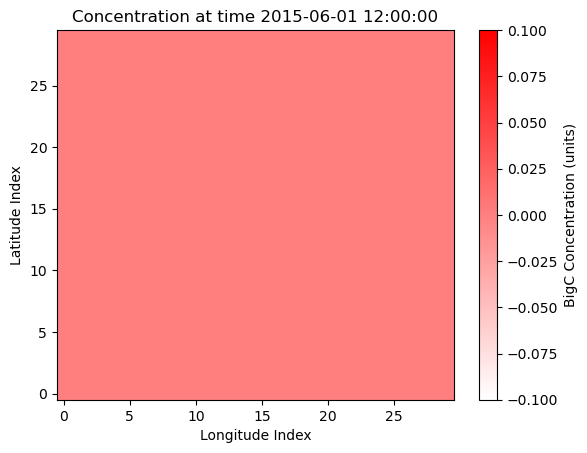

Plotting time step 60


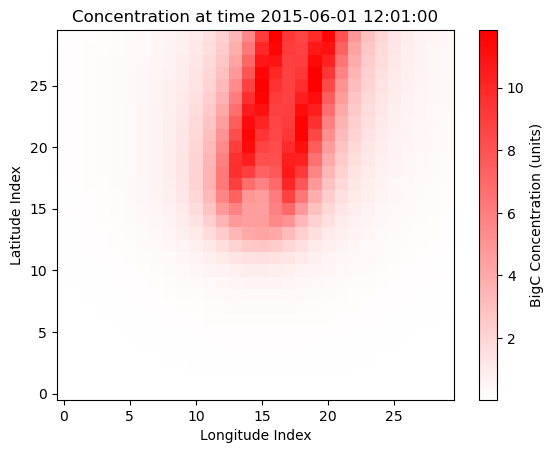

Plotting time step 120


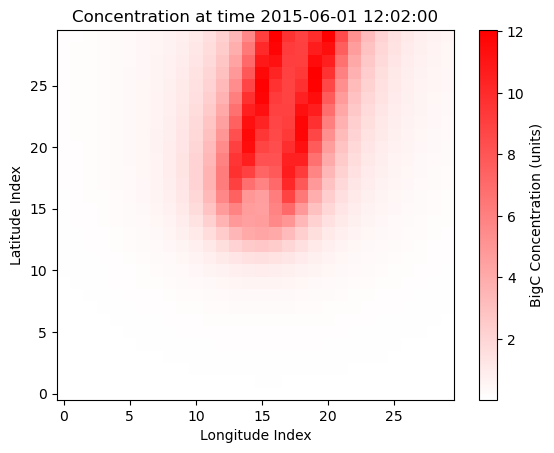

Plotting time step 180


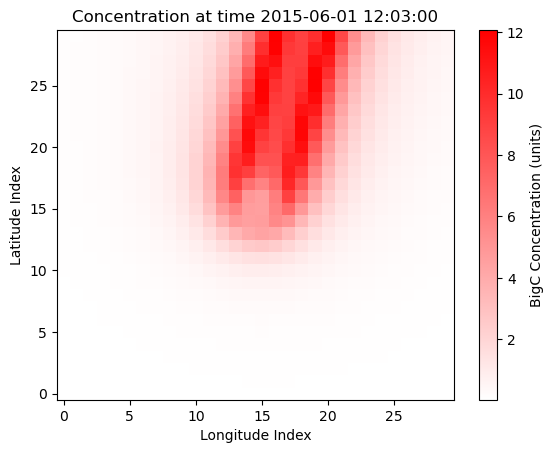

Plotting time step 240


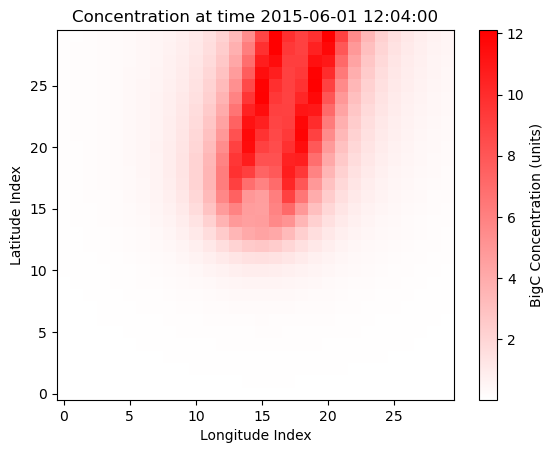

Plotting time step 300


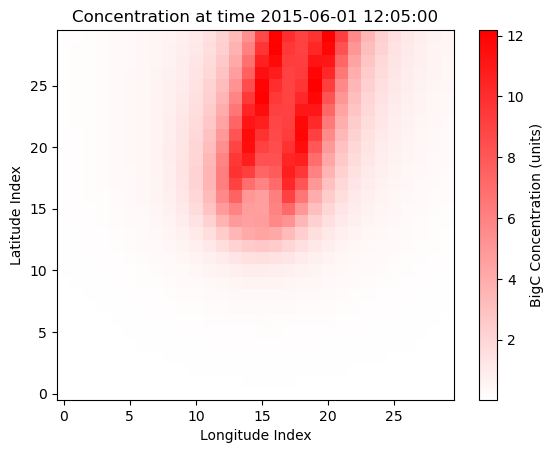

Plotting time step 360


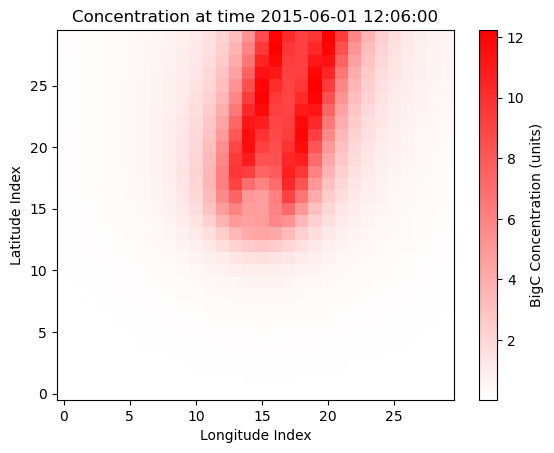

Plotting time step 420


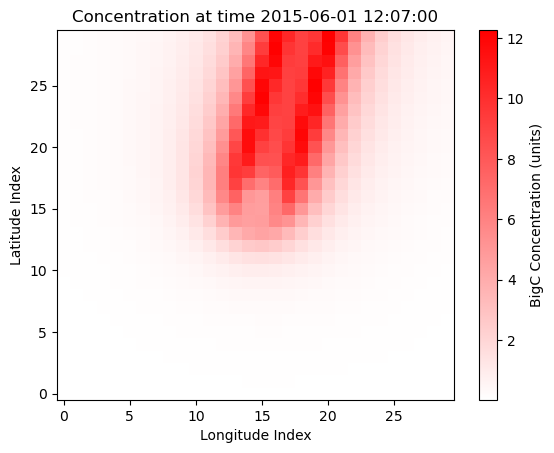

Plotting time step 480


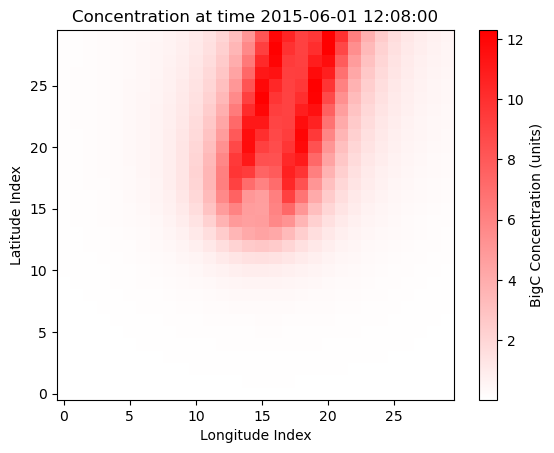

Plotting time step 540


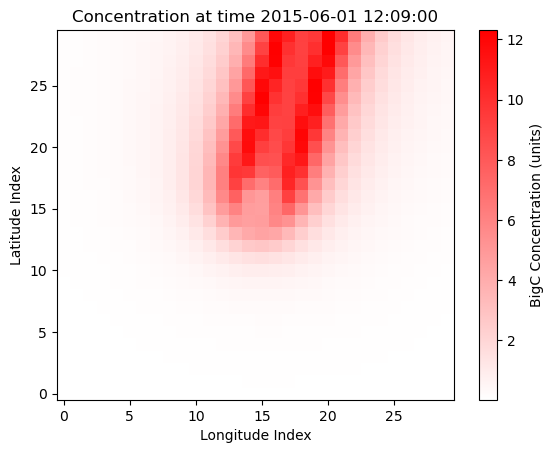

Plotting time step 600


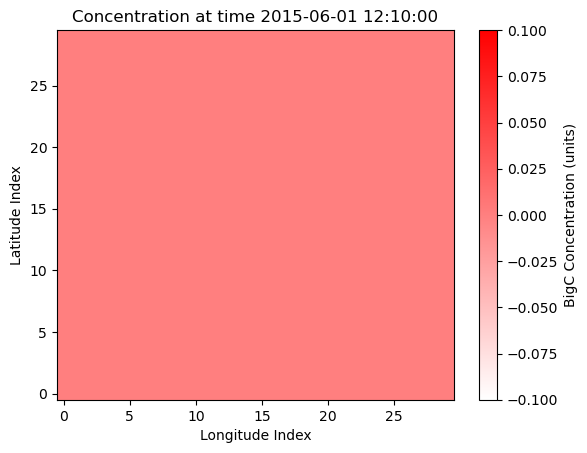

Plotting time step 660


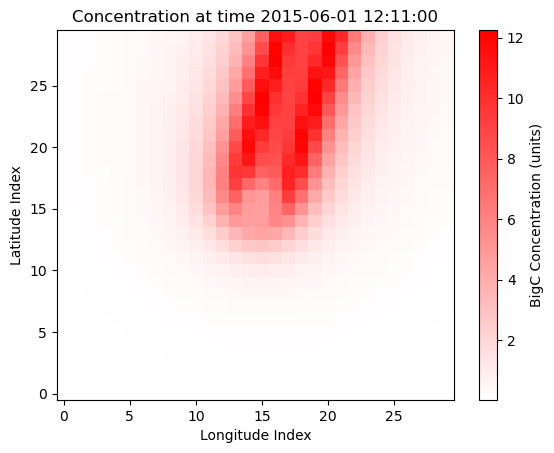

Plotting time step 720


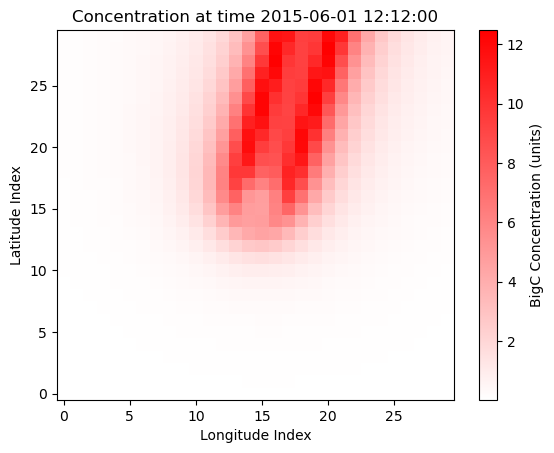

Plotting time step 780


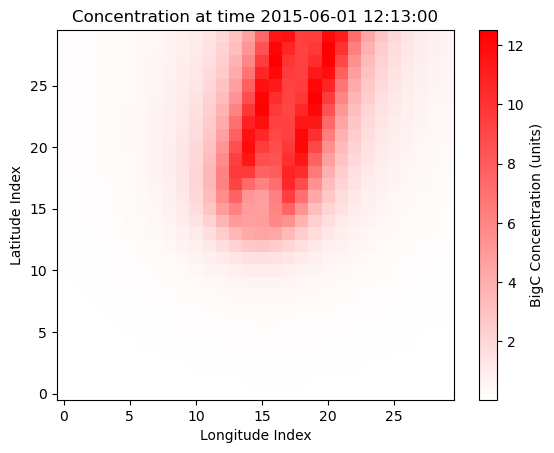

Plotting time step 840


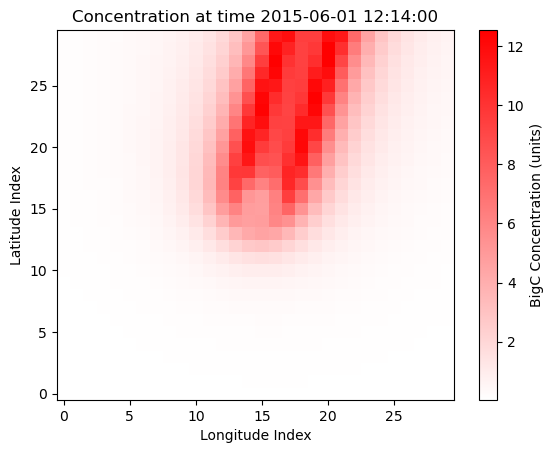

Plotting time step 900


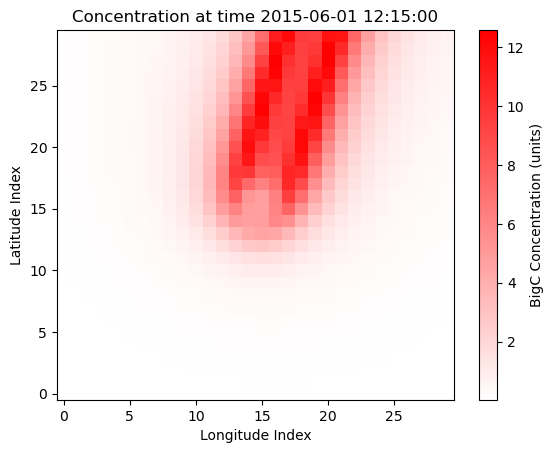

Plotting time step 960


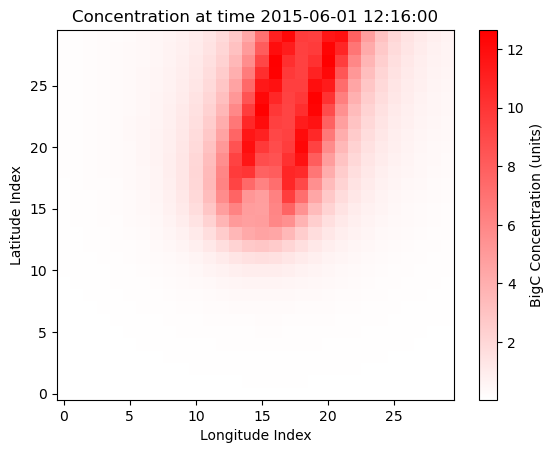

Plotting time step 1020


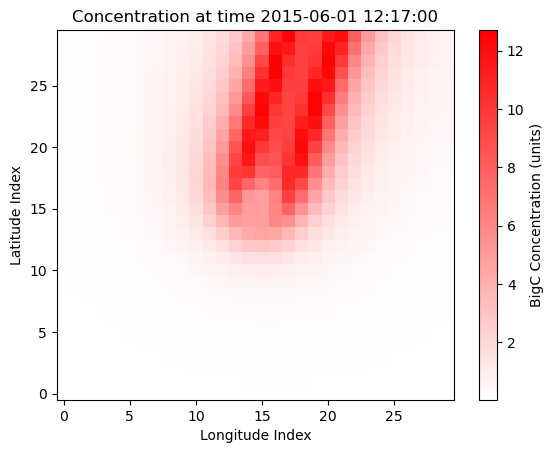

Plotting time step 1080


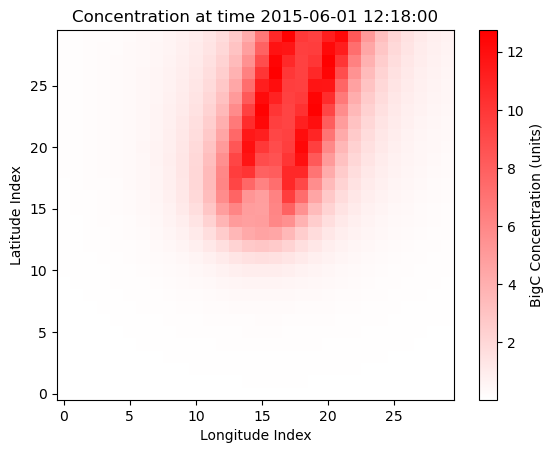

Plotting time step 1140


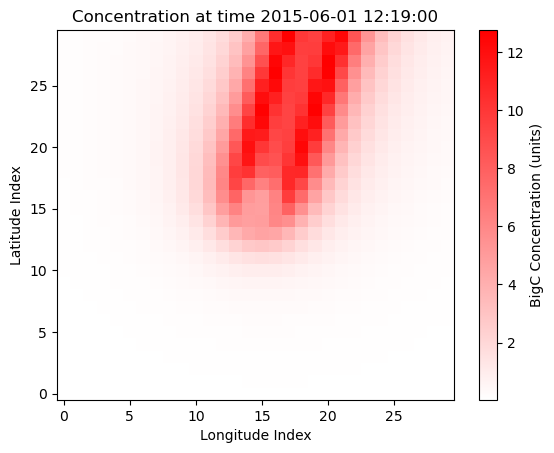

Plotting time step 1200


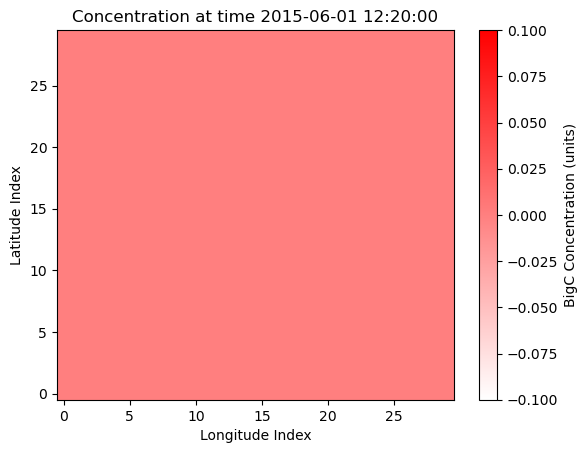

Plotting time step 1260


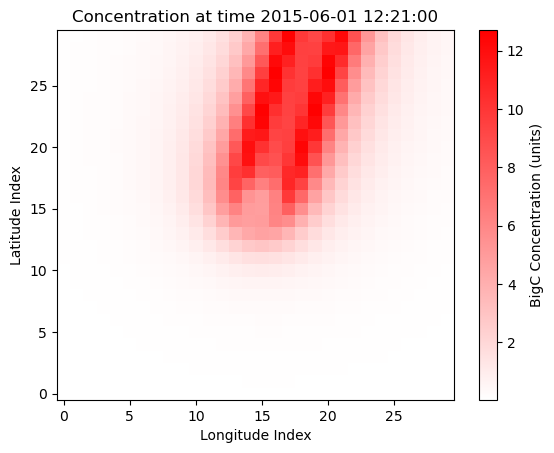

Plotting time step 1320


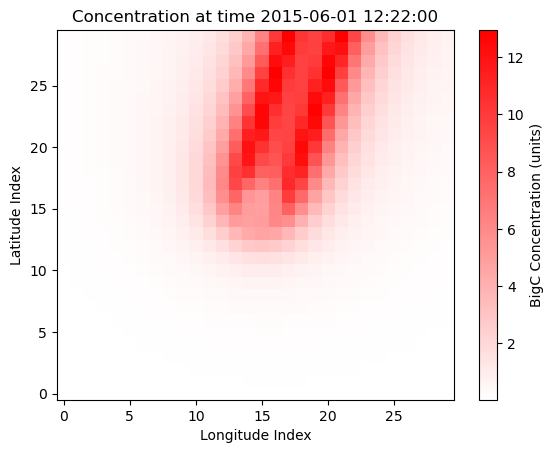

Plotting time step 1380


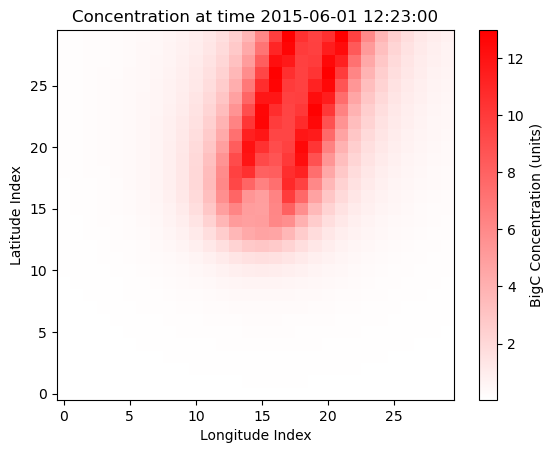

Plotting time step 1440


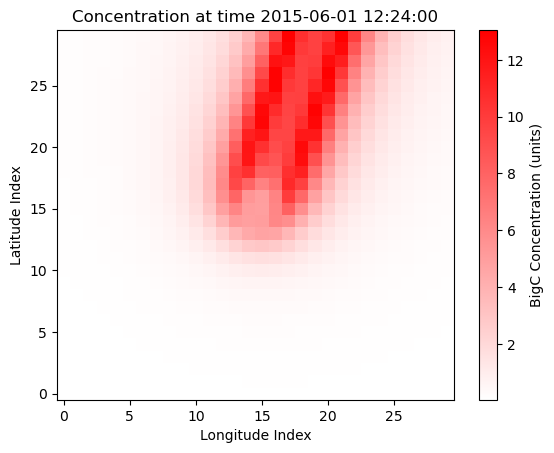

Plotting time step 1500


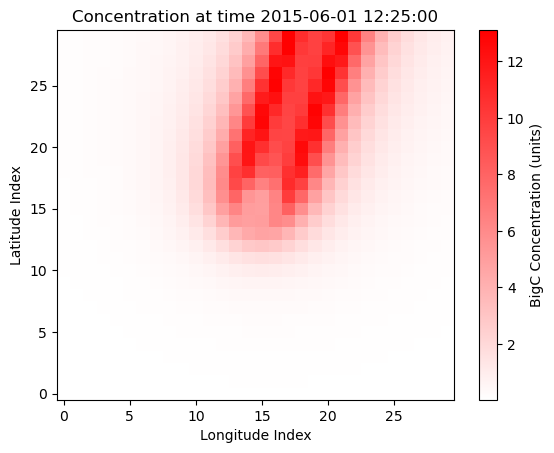

Plotting time step 1560


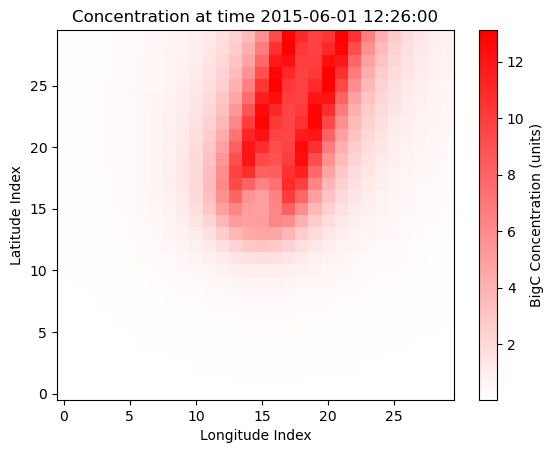

Plotting time step 1620


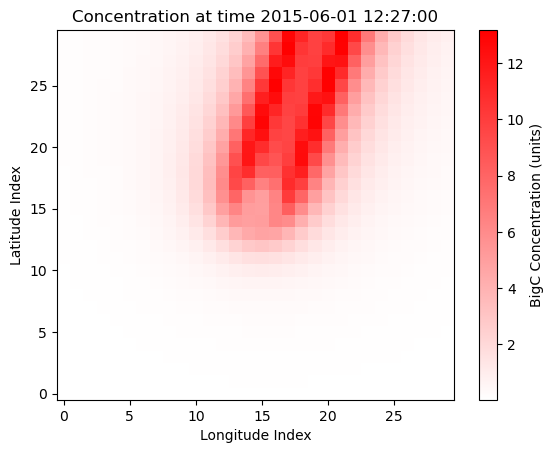

Plotting time step 1680


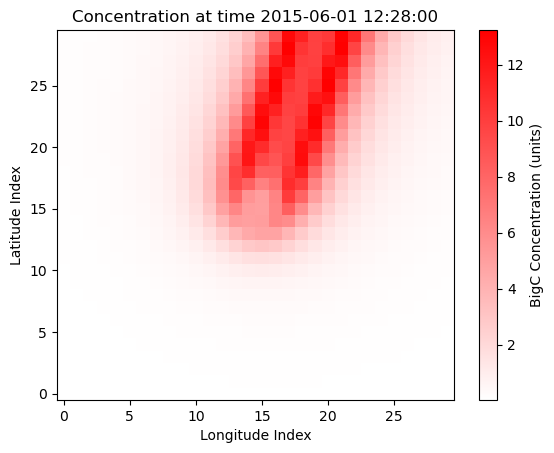

Plotting time step 1740


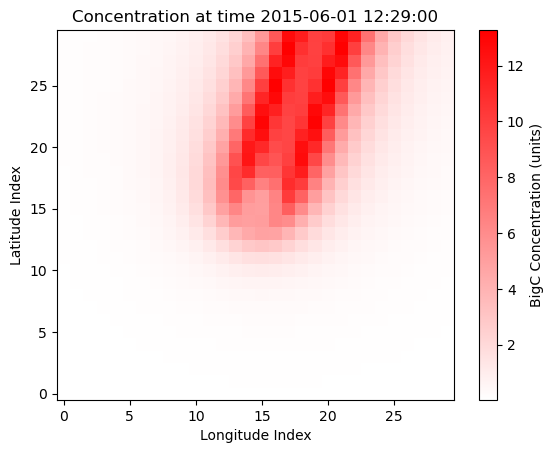

Plotting time step 1800


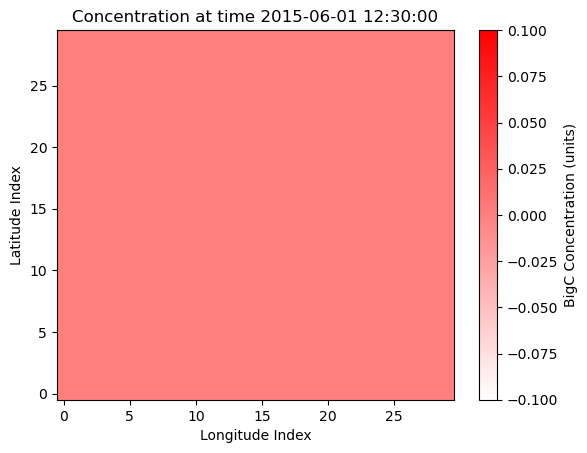

Plotting time step 1860


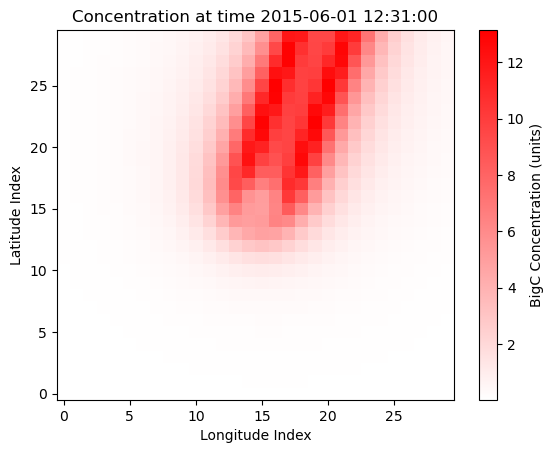

Plotting time step 1920


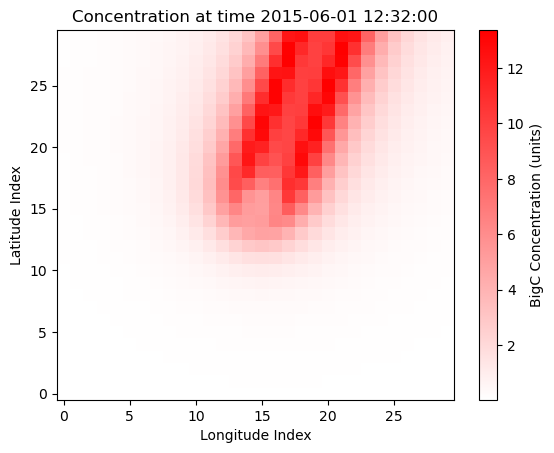

Plotting time step 1980


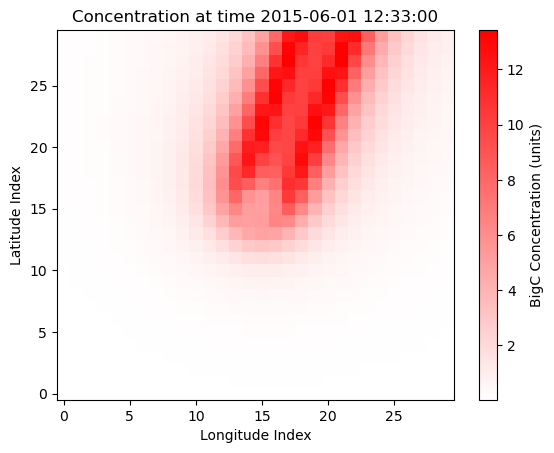

Plotting time step 2040


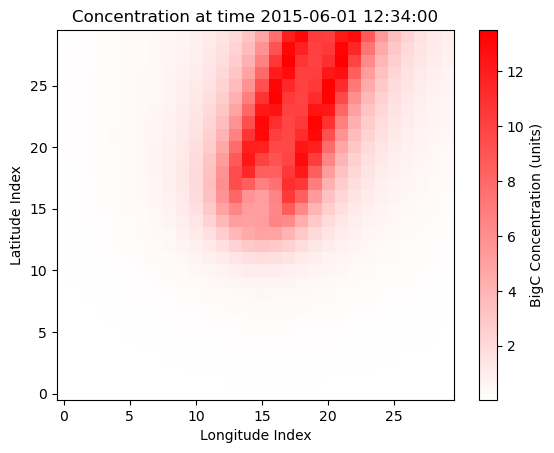

Plotting time step 2100


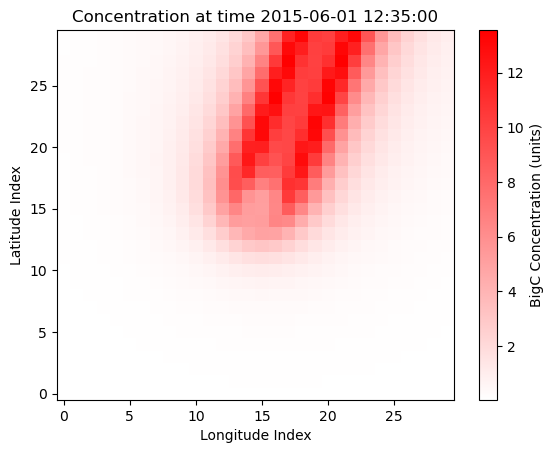

Plotting time step 2160


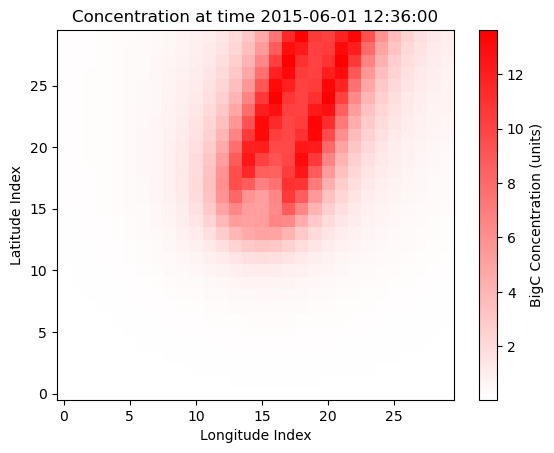

Plotting time step 2220


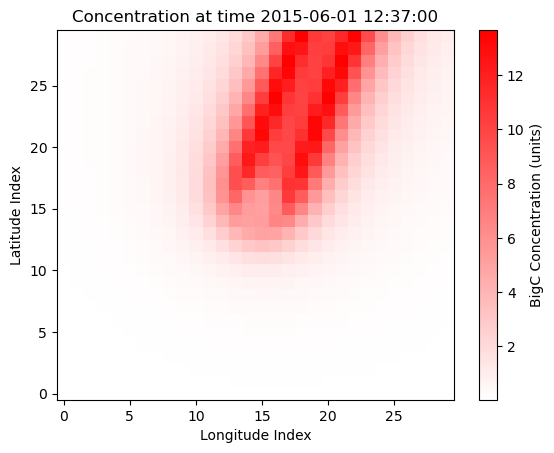

Plotting time step 2280


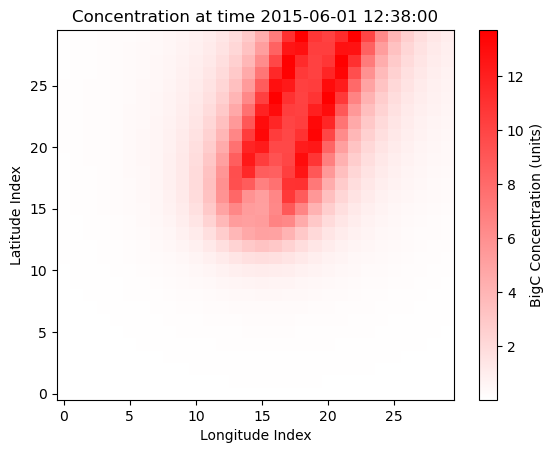

Plotting time step 2340


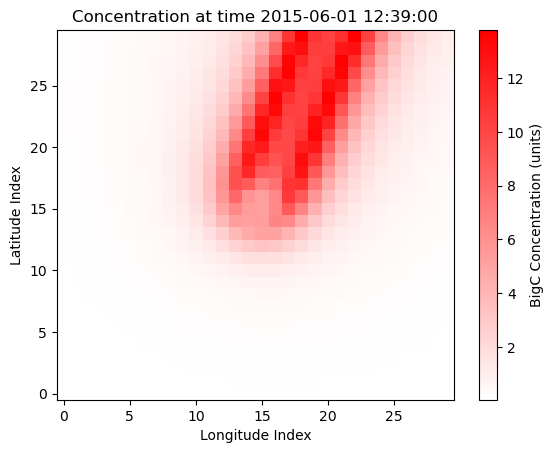

Plotting time step 2400


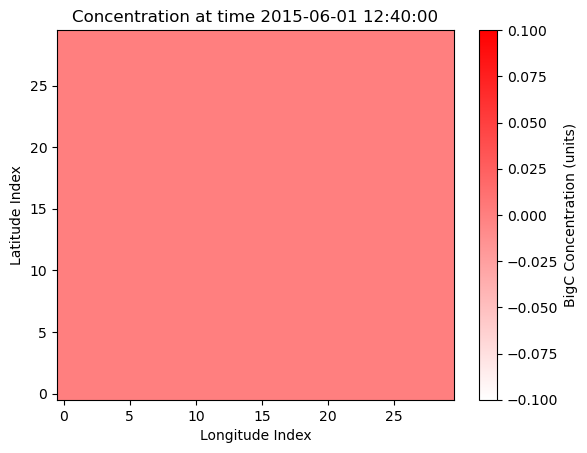

Plotting time step 2460


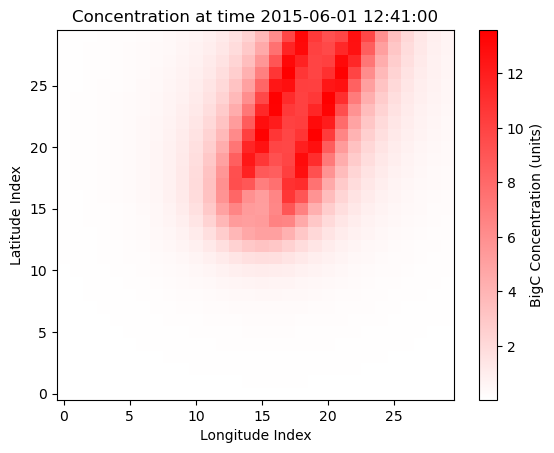

Plotting time step 2520


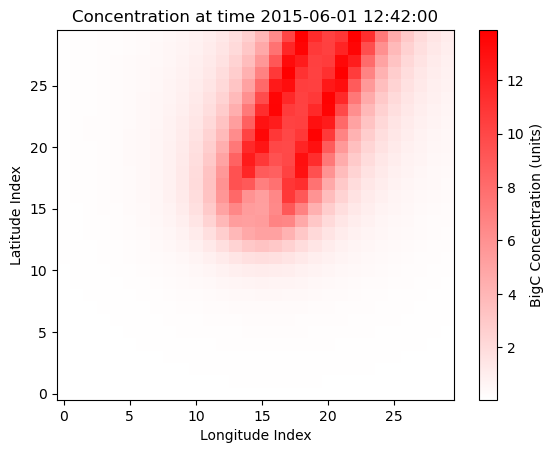

Plotting time step 2580


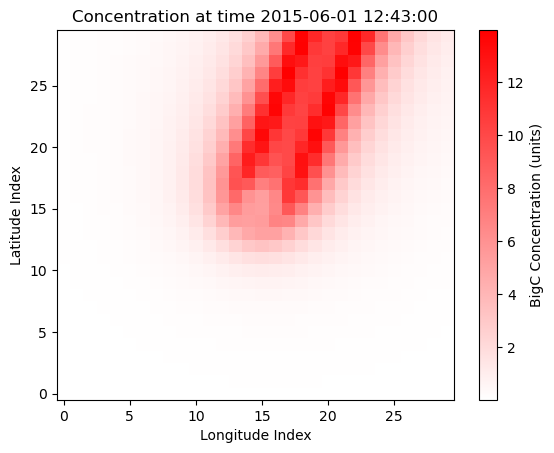

Plotting time step 2640


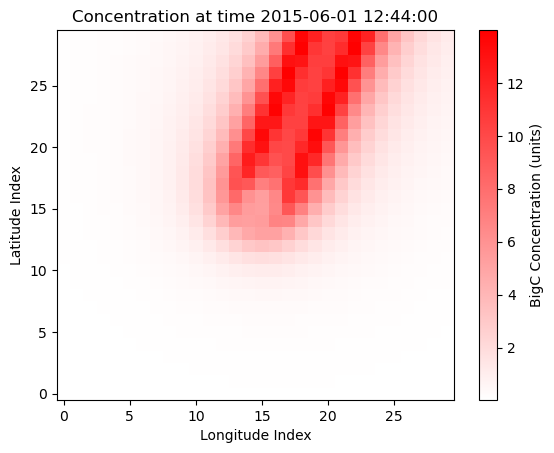

Plotting time step 2700


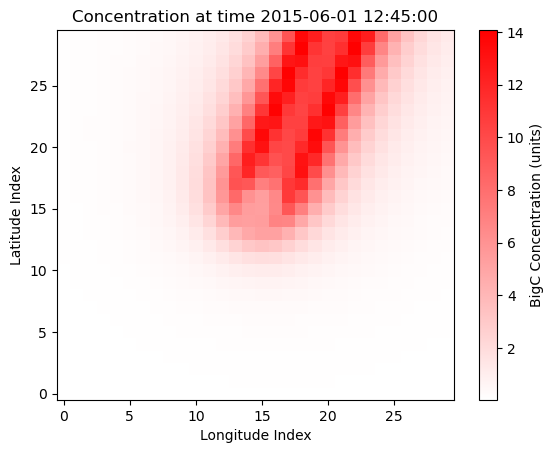

Plotting time step 2760


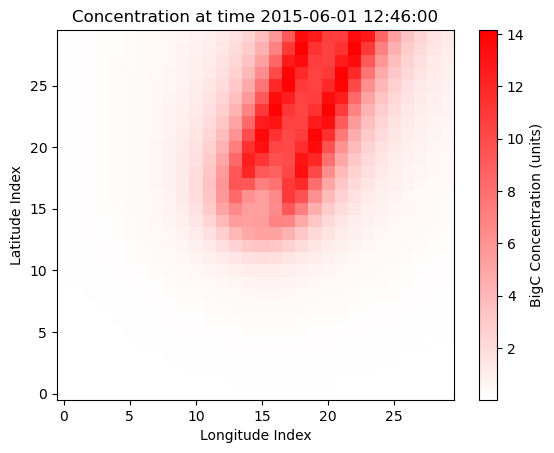

Plotting time step 2820


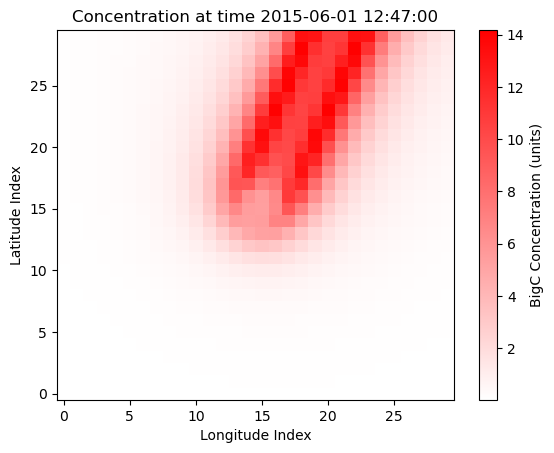

Plotting time step 2880


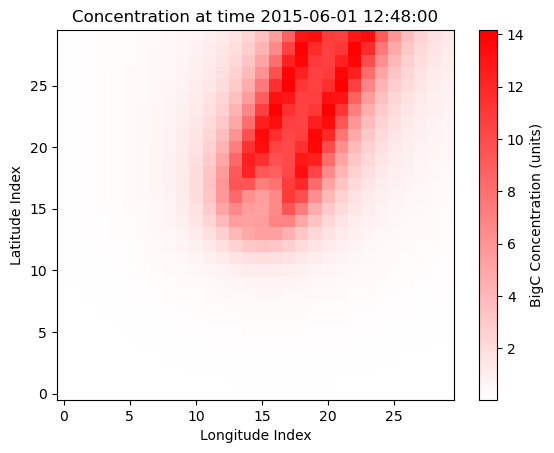

Plotting time step 2940


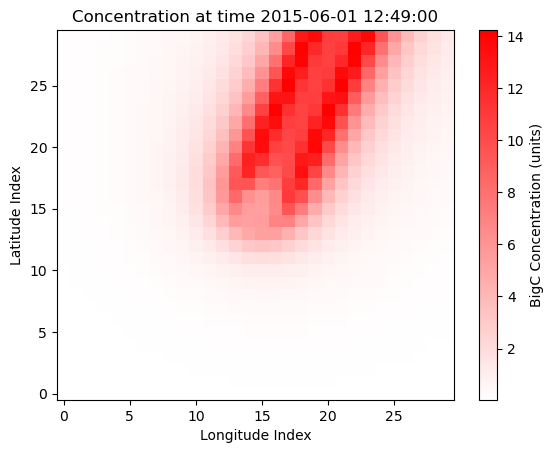

Plotting time step 3000


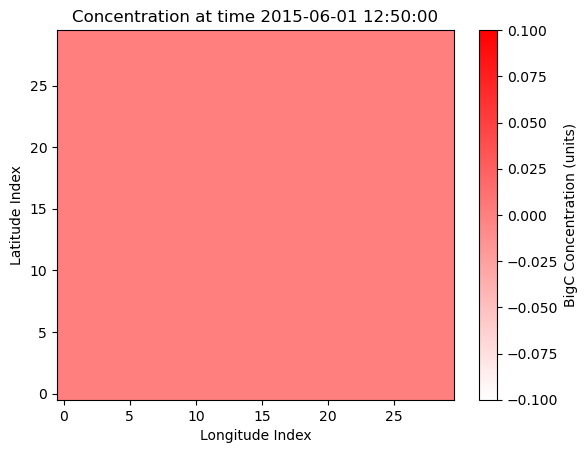

Plotting time step 3060


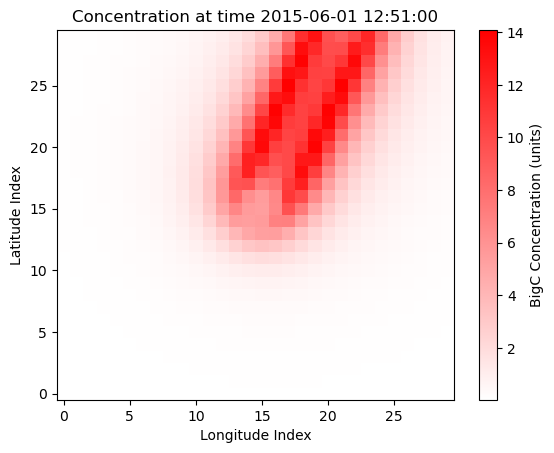

Plotting time step 3120


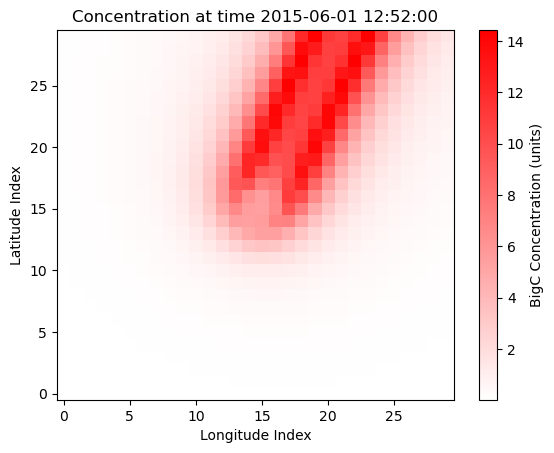

Plotting time step 3180


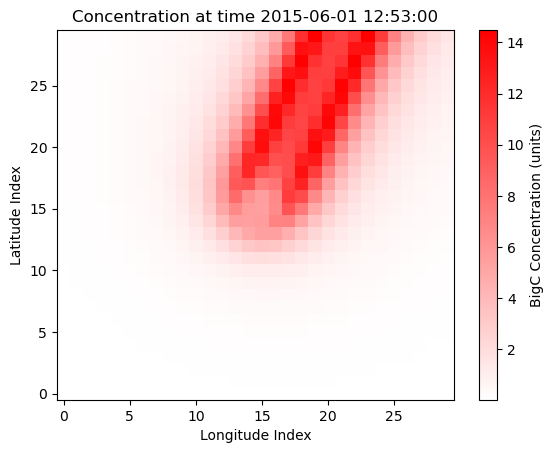

Plotting time step 3240


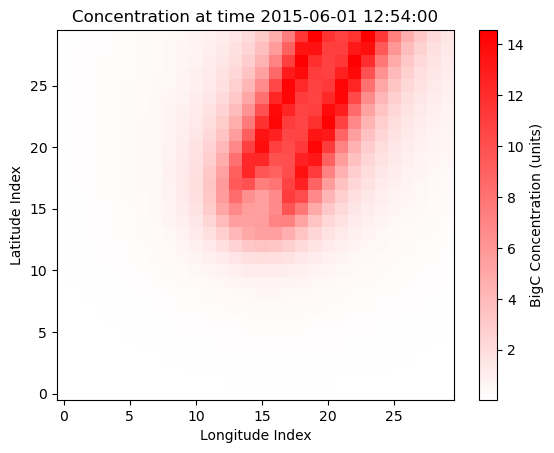

Plotting time step 3300


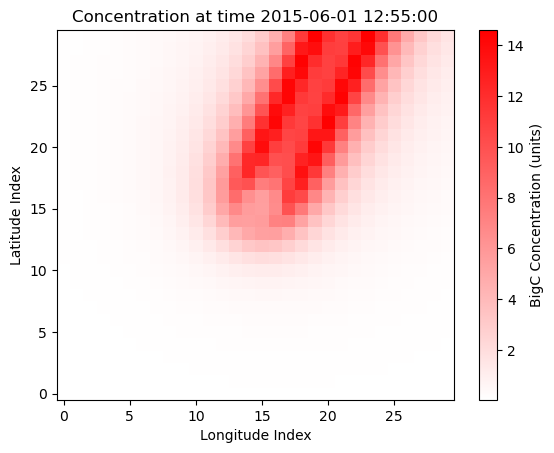

Plotting time step 3360


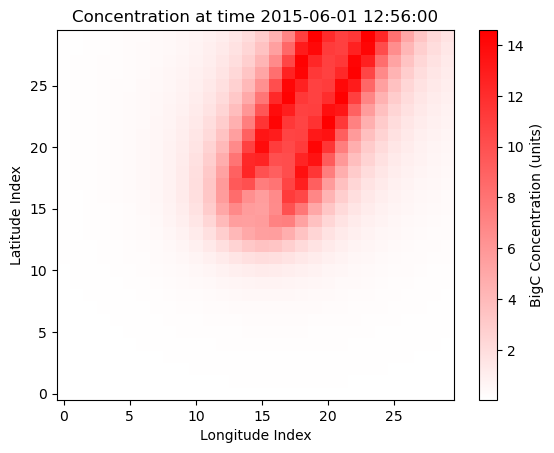

Plotting time step 3420


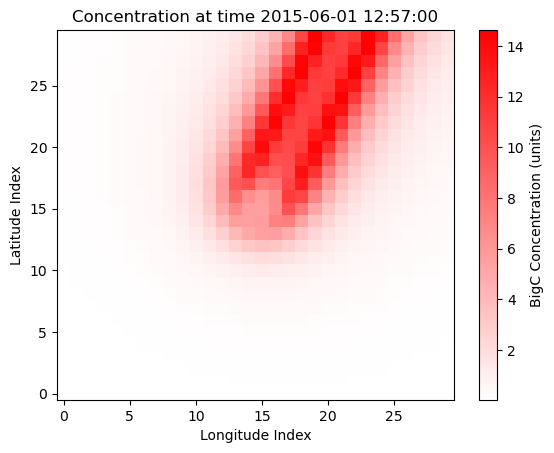

Plotting time step 3480


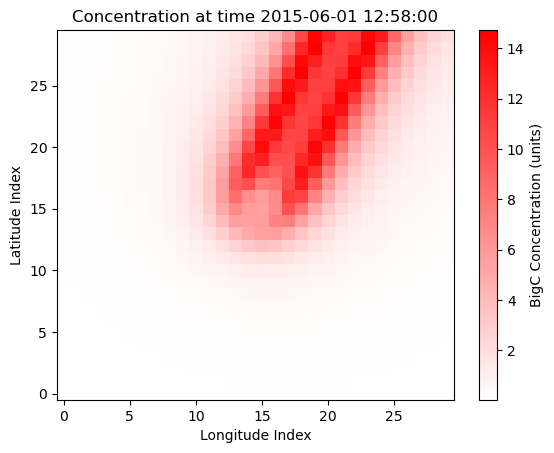

Plotting time step 3540


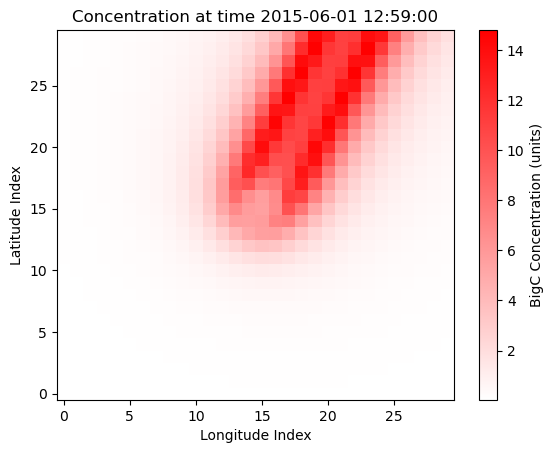

big_C shape (3600, 30, 30, 10)
[   0    0    0 ... 3599 3599 3599]
debug grids [384579.44543459 384582.89371046 384586.34198632 384589.79026218
 384593.23853804 384596.6868139  384600.13508977 384603.58336563
 384607.03164149]
unique [3768354.62107789 3768358.06935375 3768361.51762961 3768364.96590548
 3768368.41418134 3768371.8624572  3768375.31073306 3768378.75900892
 3768382.20728479 3768385.65556065 3768389.10383651 3768392.55211237
 3768396.00038823 3768399.4486641  3768402.89693996 3768406.34521582
 3768409.79349168 3768413.24176754 3768416.69004341 3768420.13831927
 3768423.58659513 3768427.03487099 3768430.48314685 3768433.93142272
 3768437.37969858 3768440.82797444 3768444.2762503  3768447.72452617
 3768451.17280203 3768454.62107789]
unique [384579.44543459 384582.89371046 384586.34198632 384589.79026218
 384593.23853804 384596.6868139  384600.13508977 384603.58336563
 384607.03164149 384610.47991735 384613.92819321 384617.37646908
 384620.82474494 384624.2730208  384627.72129

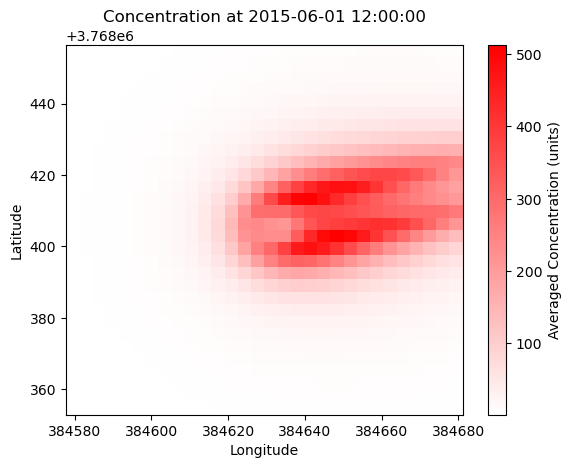

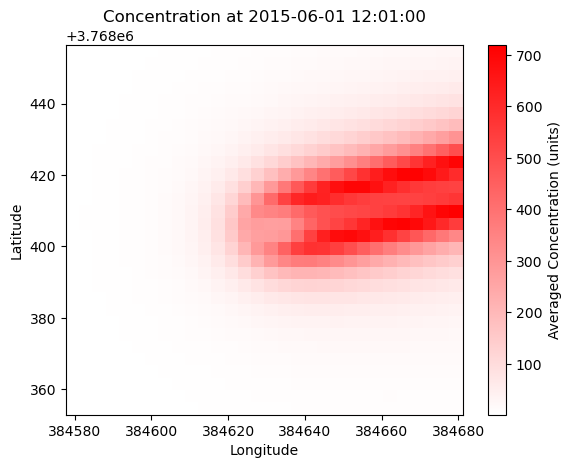

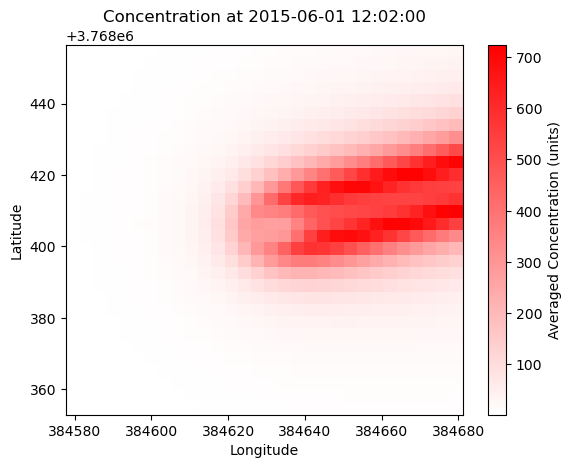

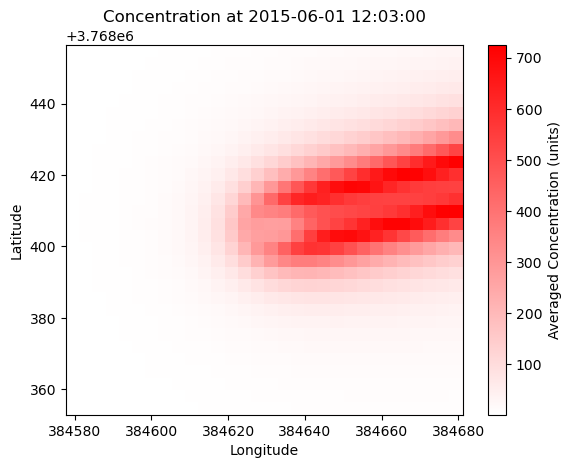

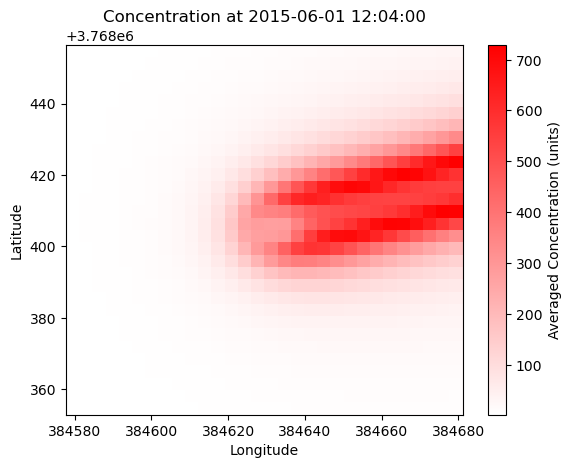

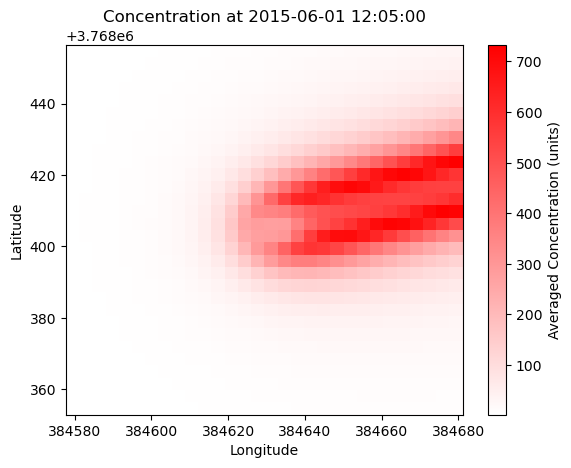

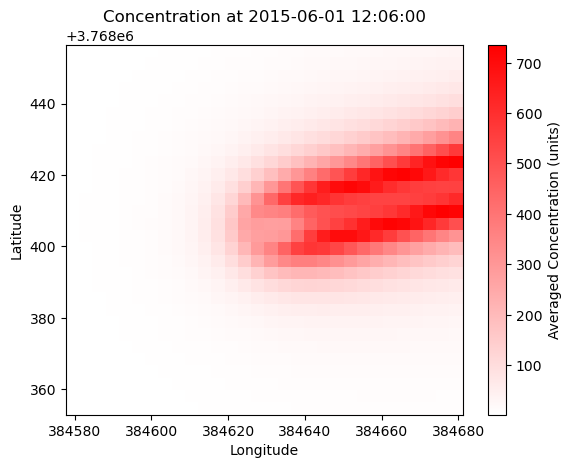

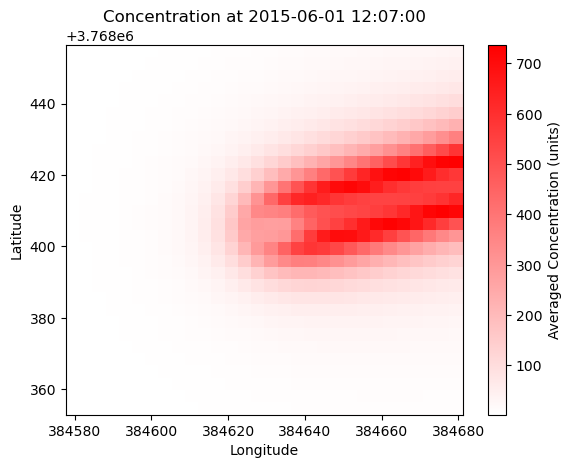

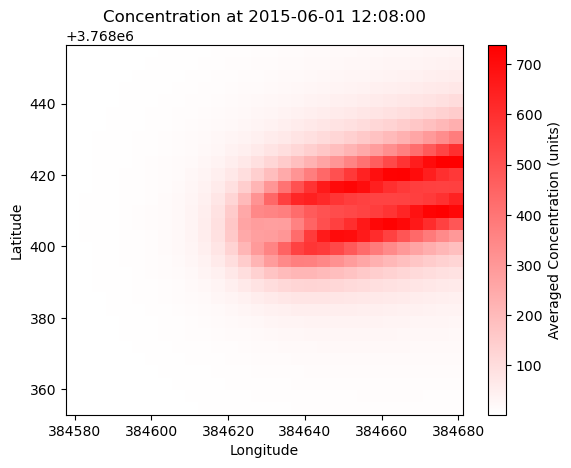

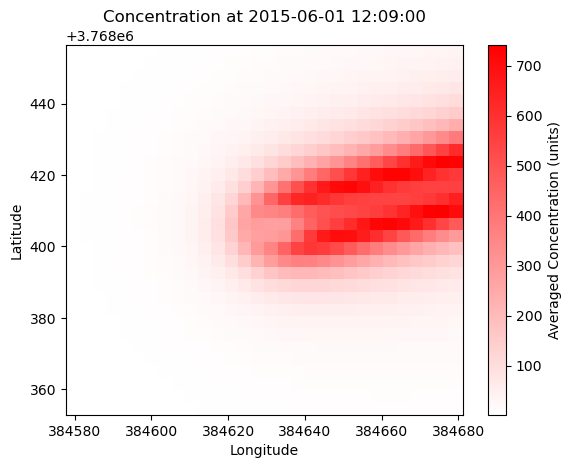

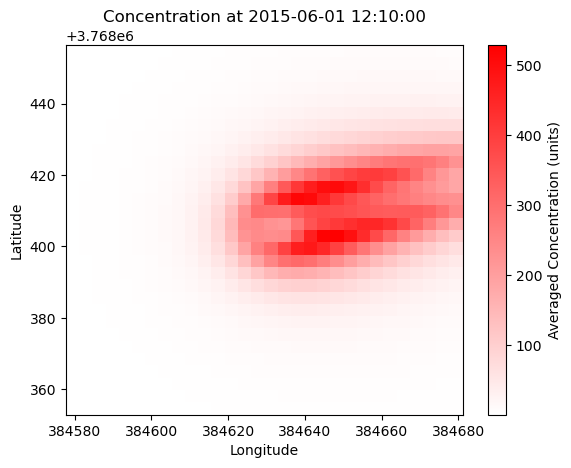

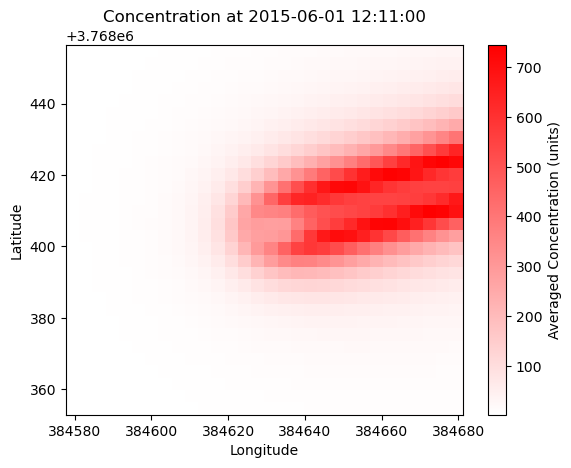

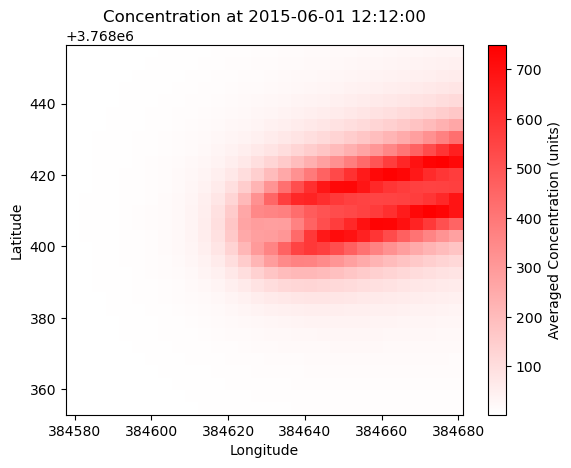

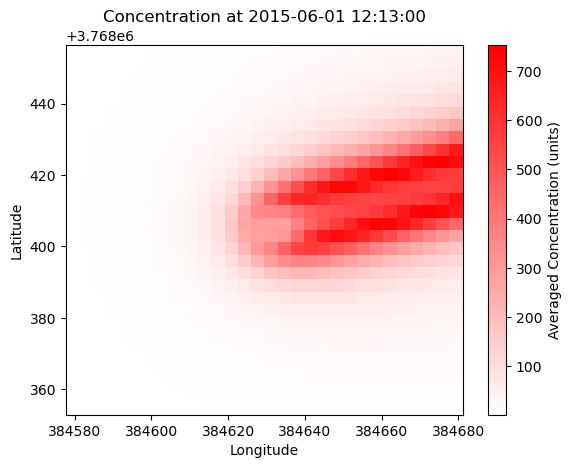

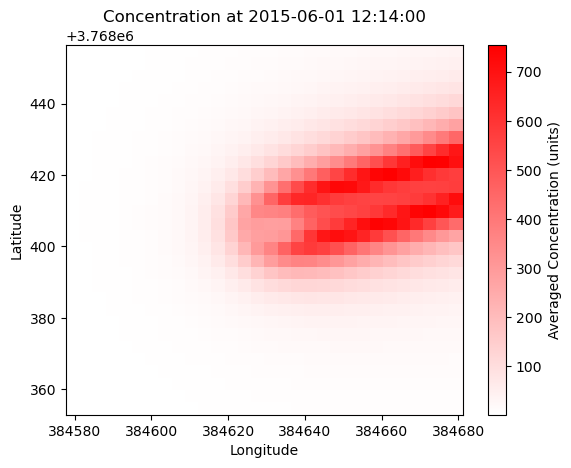

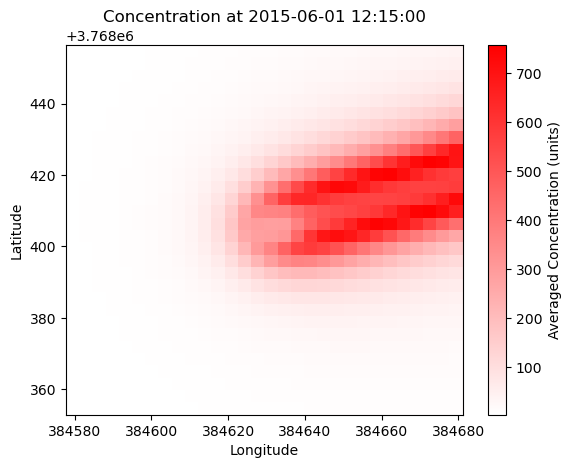

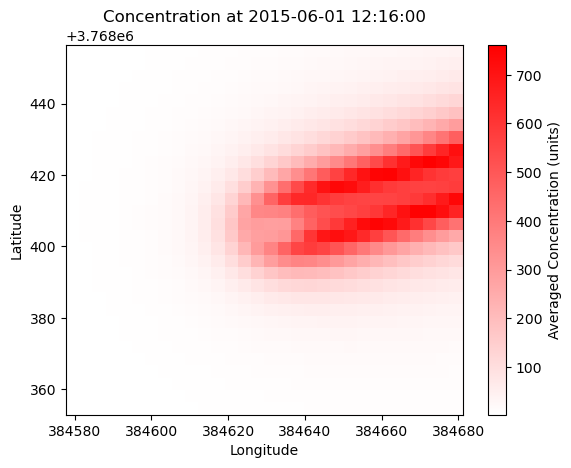

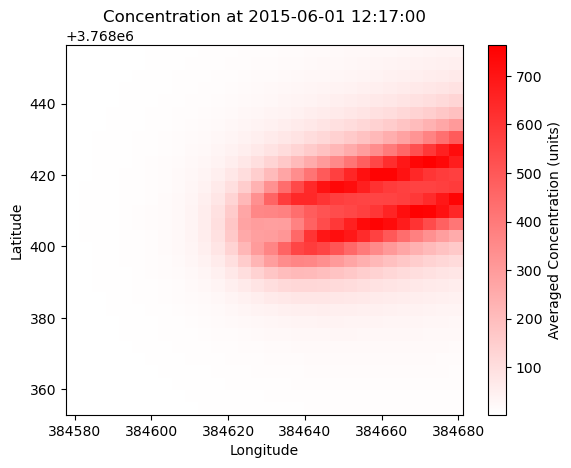

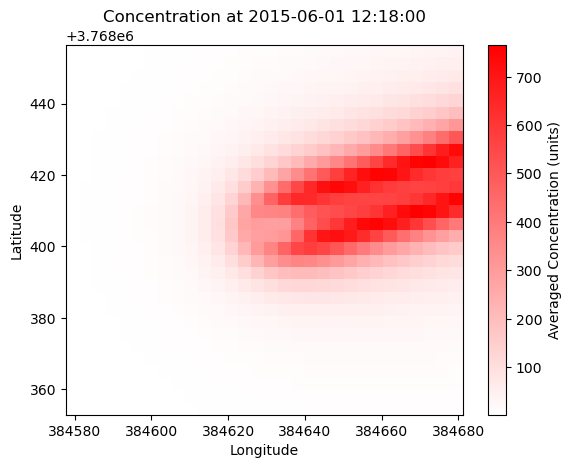

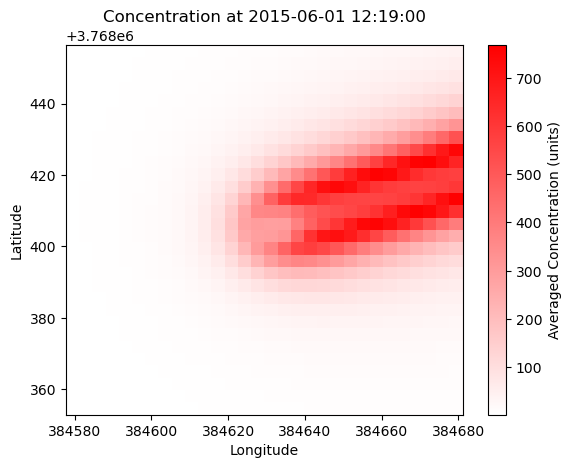

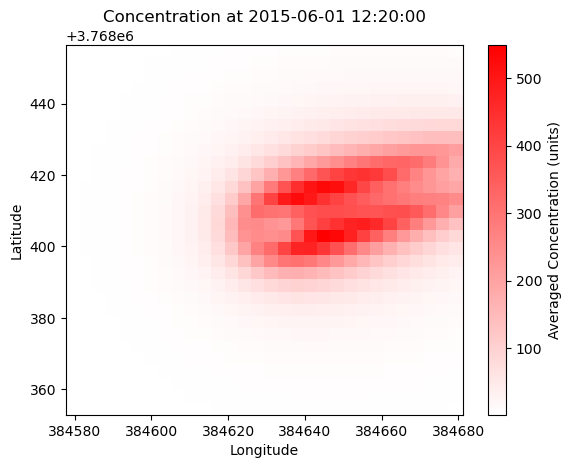

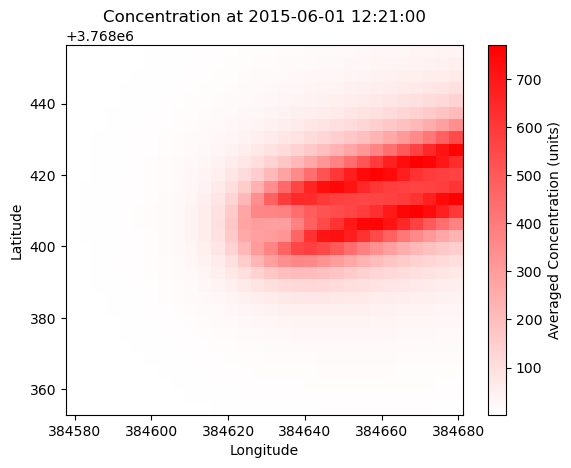

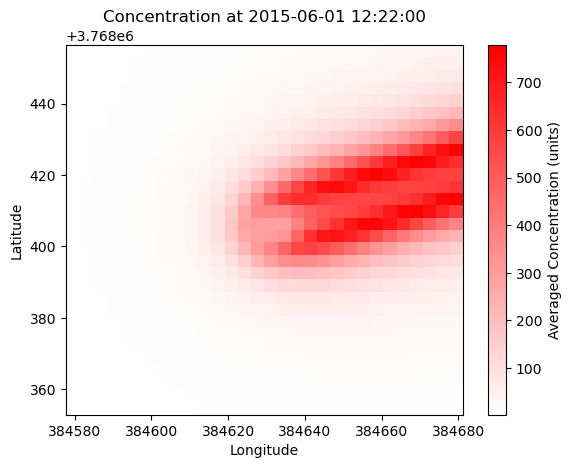

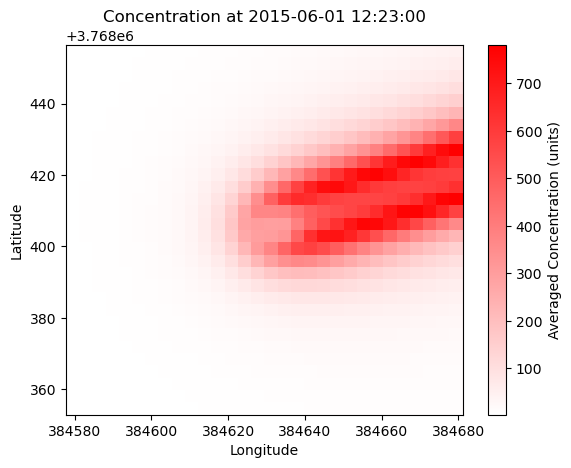

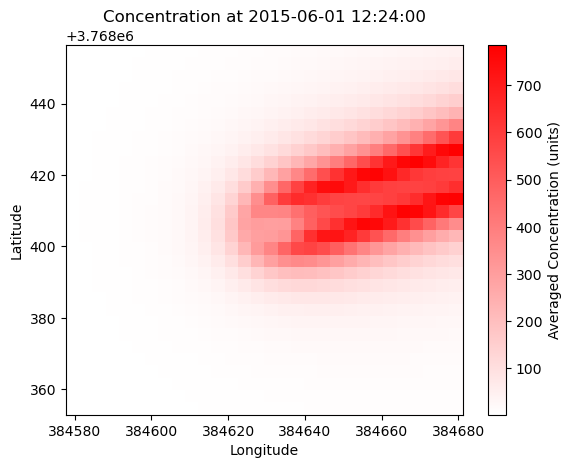

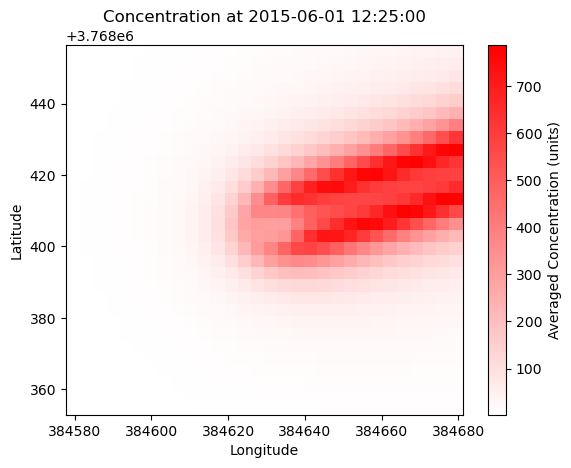

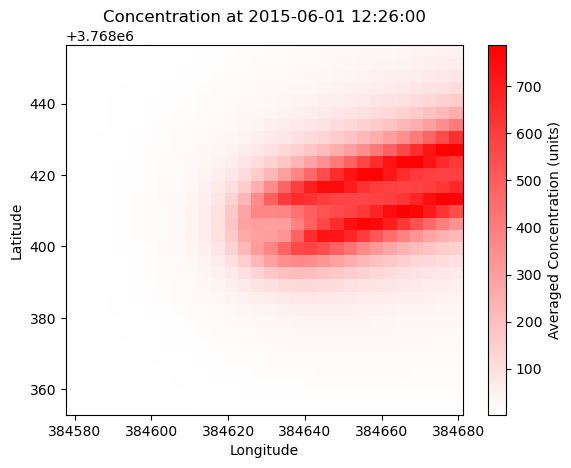

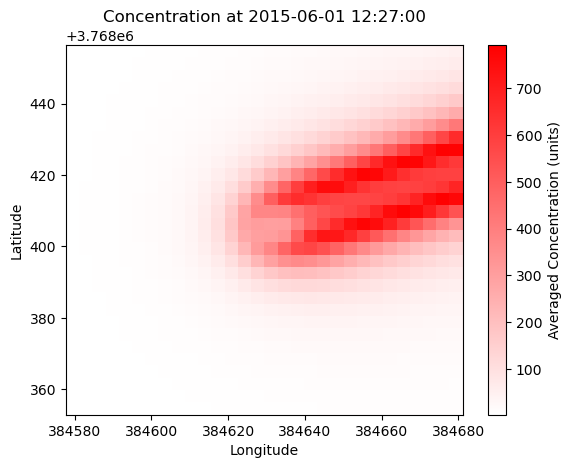

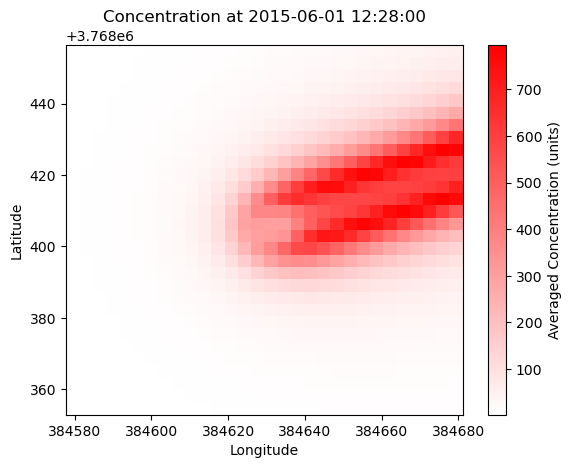

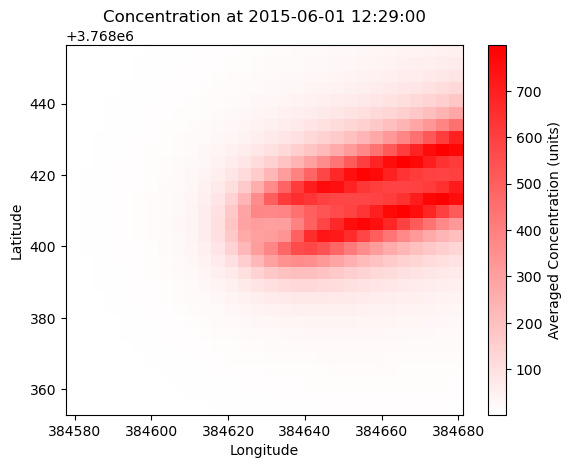

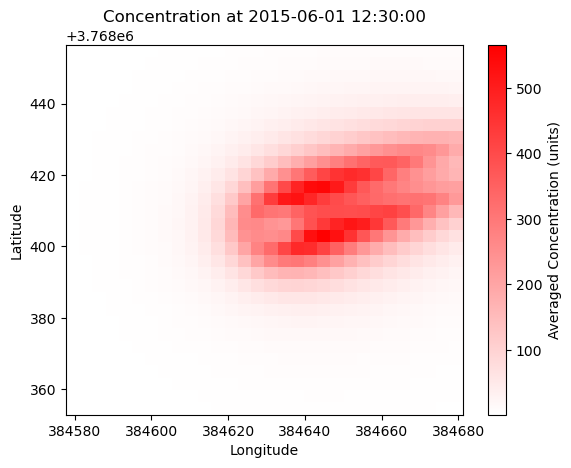

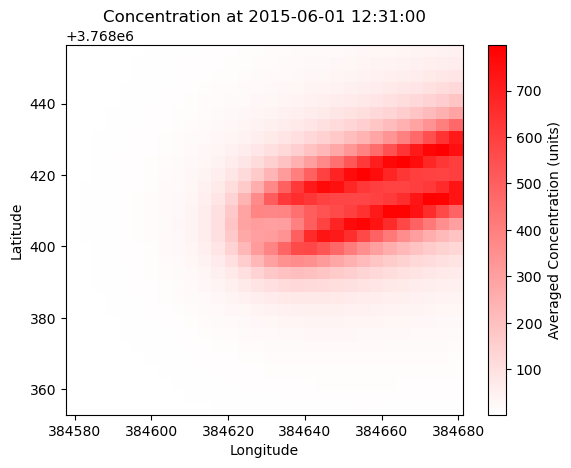

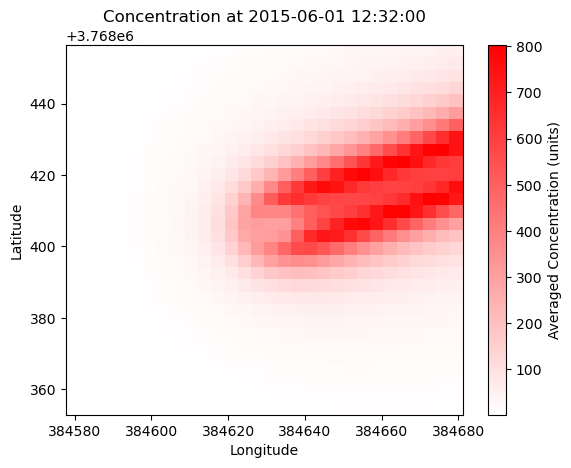

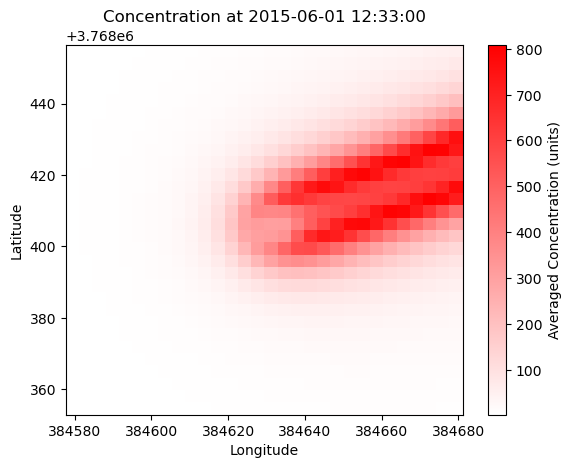

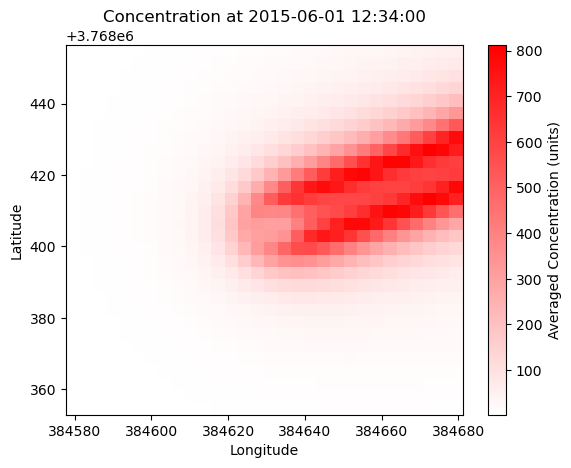

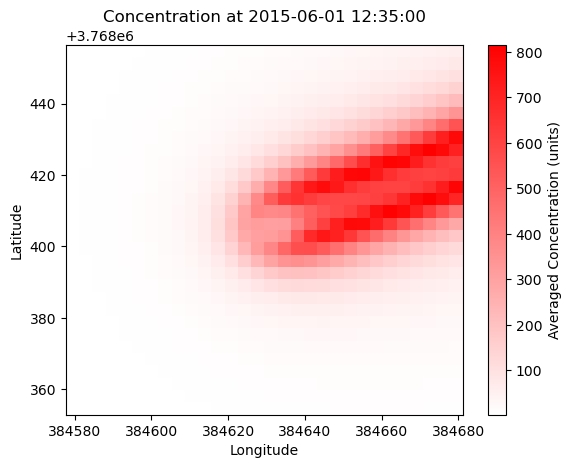

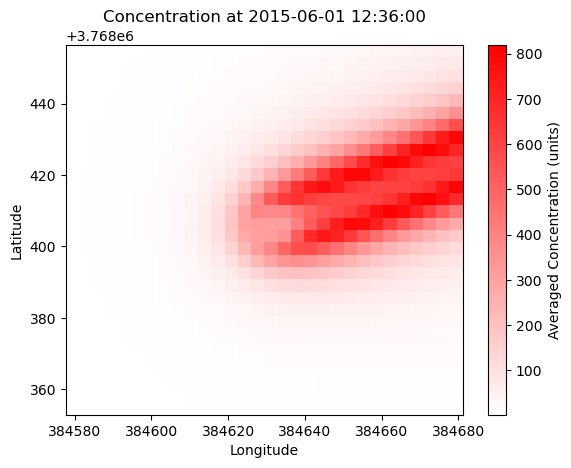

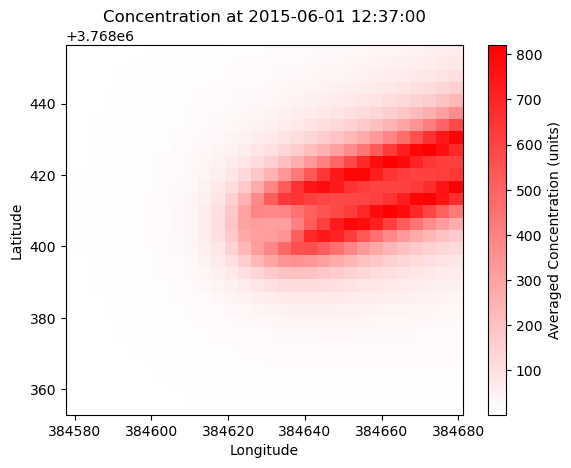

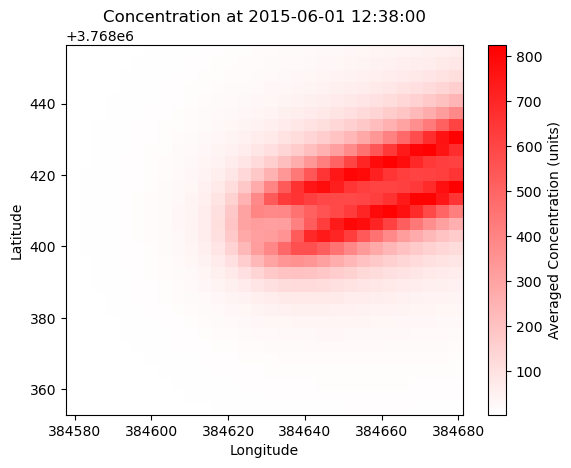

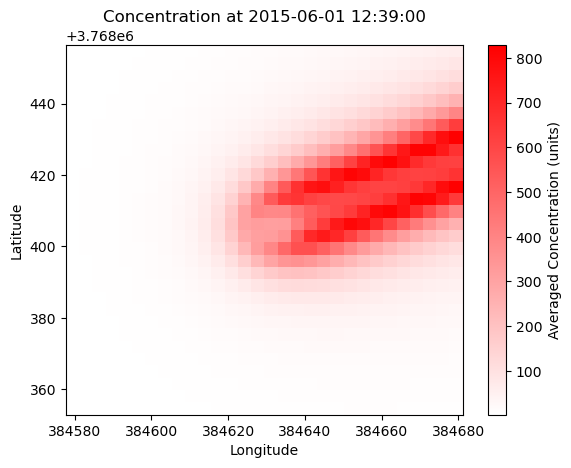

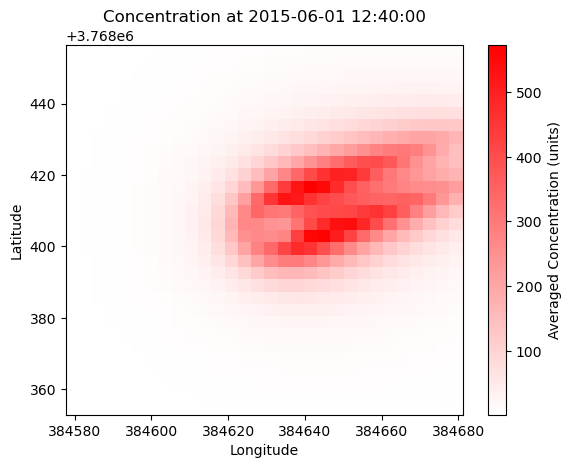

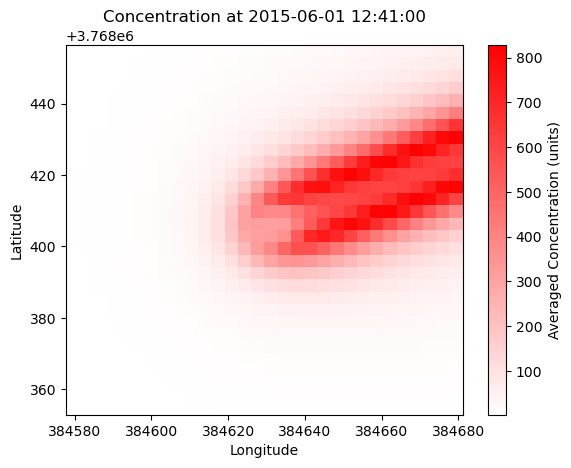

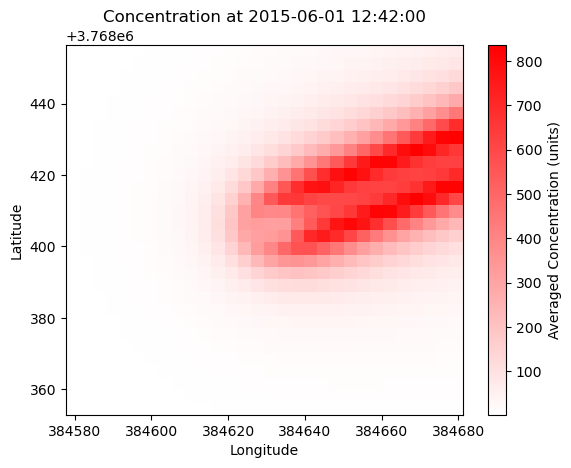

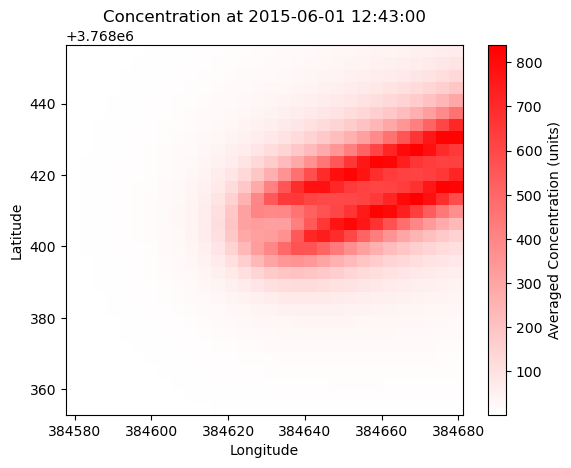

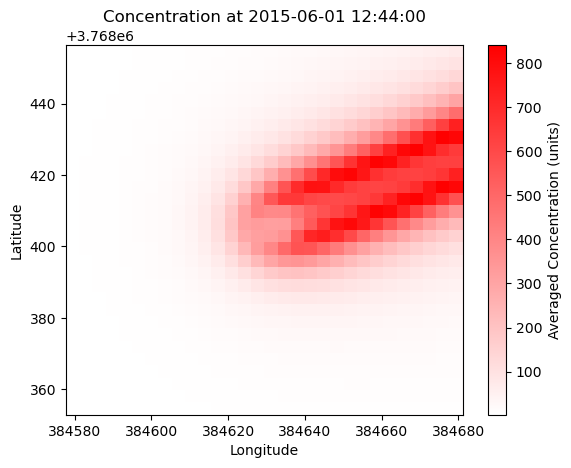

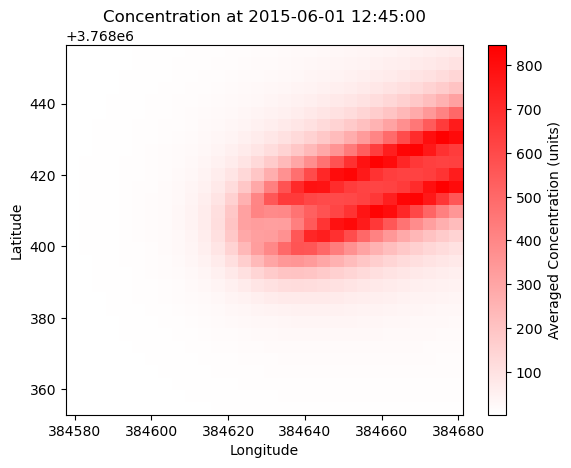

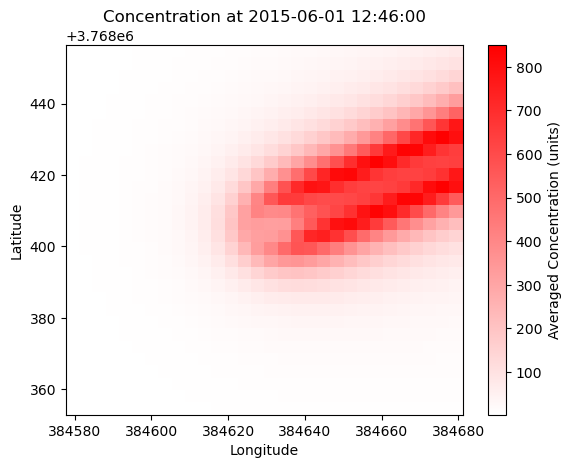

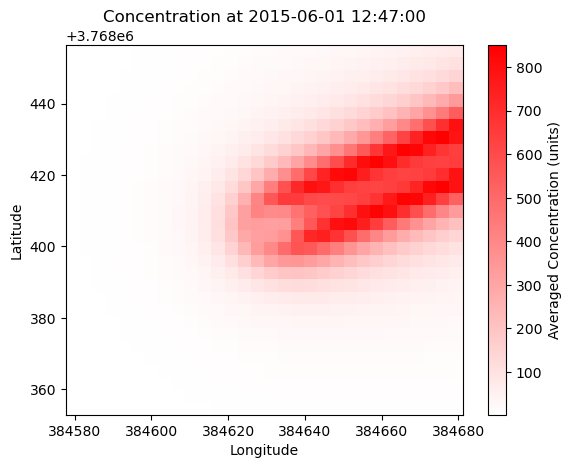

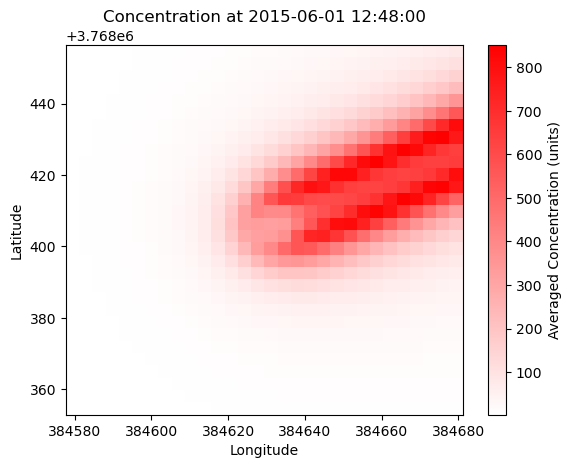

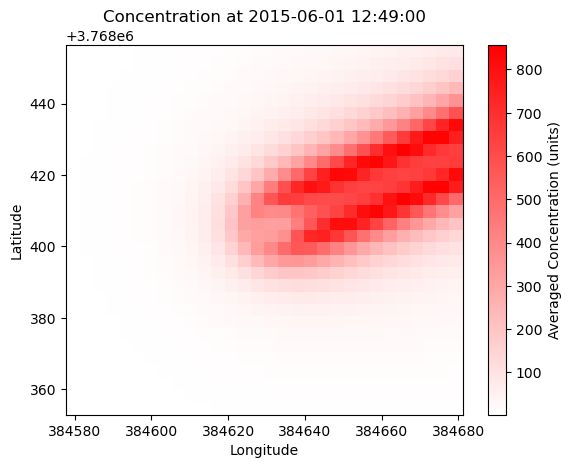

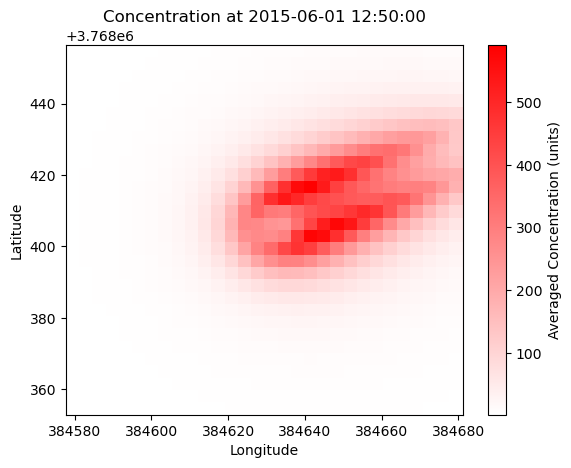

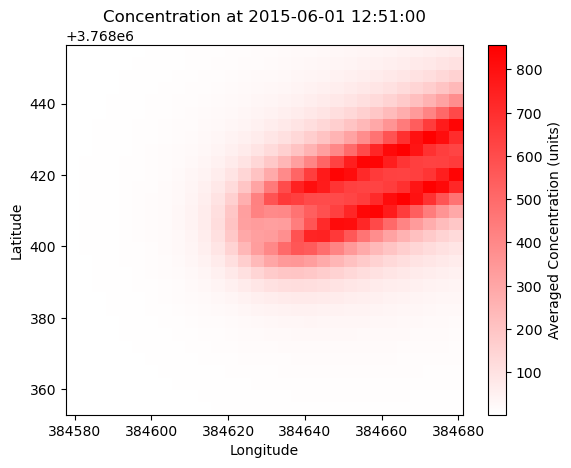

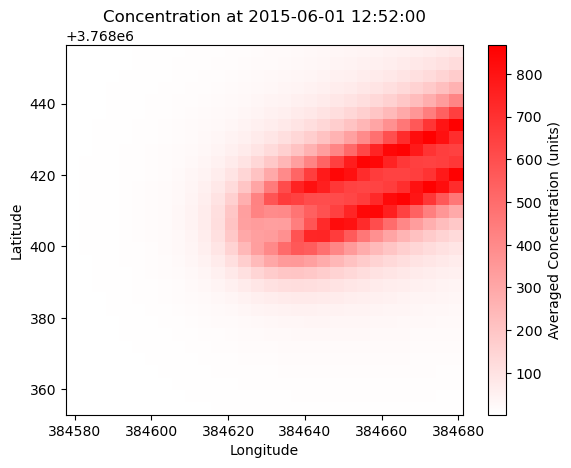

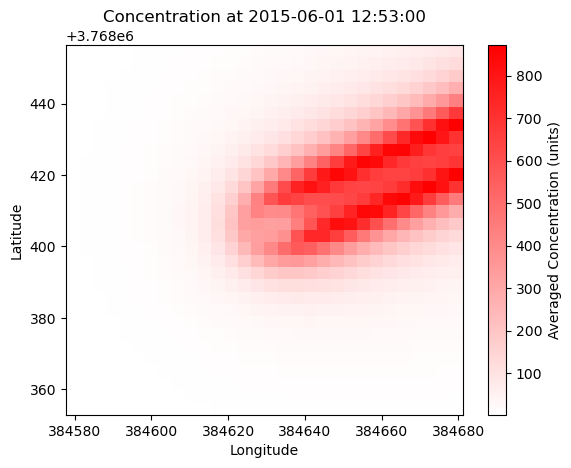

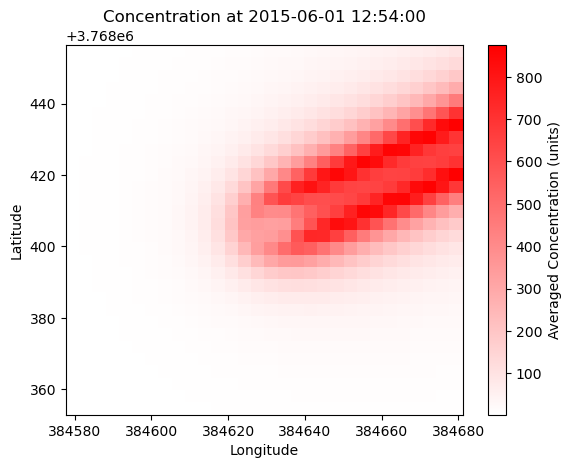

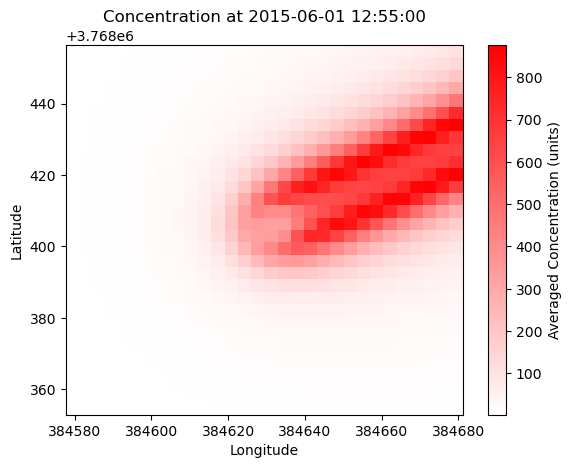

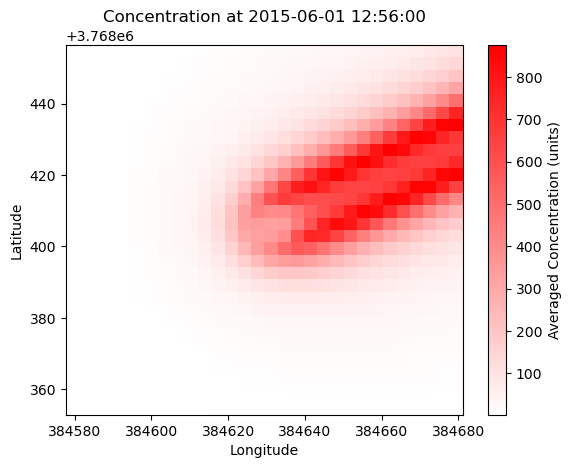

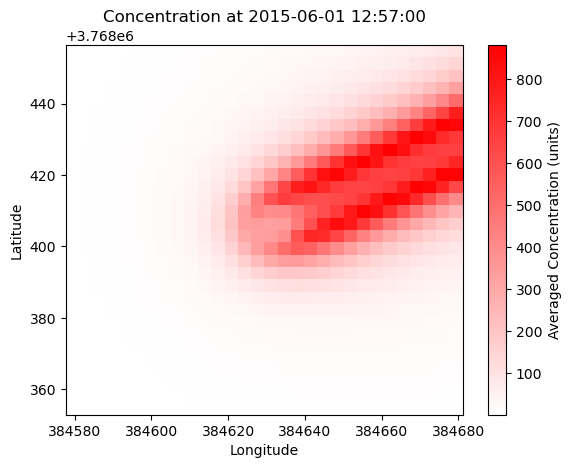

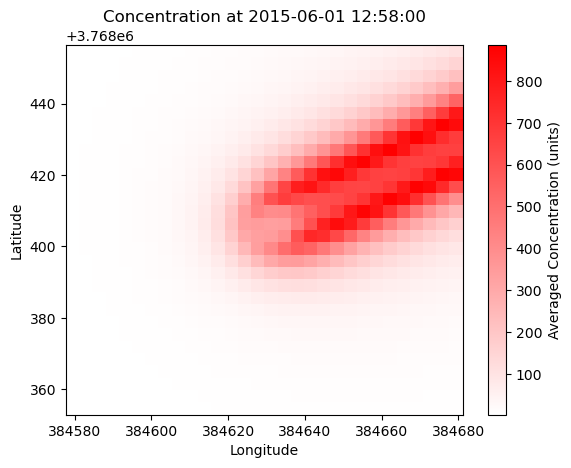

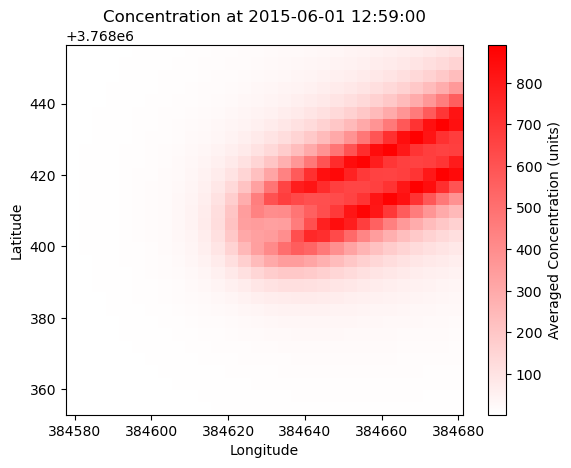

In [1]:
import numpy as np
from datetime import timedelta
from multiprocessing import Pool
import pandas as pd
from gaussian_puff_functions import *

def simulate_puff_concentration(source_index, source_locs, data, dt, emission_rate, times, chunk_size, area_size, height_levels, n_chunks):
    print(f"Source: {source_index + 1}/{len(source_locs)}")

    # Source location and conversion to UTM
    source_lat = source_locs.iloc[source_index]['lat']
    source_lon = source_locs.iloc[source_index]['lon']
    source_x, source_y = latlon_to_utm(source_lat, source_lon)
    source_z = source_locs.iloc[source_index]['height']

    # Define a 3D grid or area over which to calculate concentration
    grid_x, grid_y, grid_z = np.meshgrid(np.linspace(source_x-area_size/2, source_x+area_size/2, num=30),
                                         np.linspace(source_y-area_size/2, source_y+area_size/2, num=30),
                                         np.linspace(0, source_z + height_levels, num=10))  

    # Wind data and interpolation
    WS_x = data['u_wind']
    WS_y = data['v_wind']
    WA = data['wind_direction']
    WA_x = np.cos(WA)
    WA_y = np.sin(WA)
    WS = np.sqrt(WS_x**2 + WS_y**2)

    # Emission rates
    Q_truth = np.full((len(WS)), emission_rate)

    # Setup chunk processing
    n_ints = len(WS)-1 # ignore the last time 

    args = [(h, chunk_size, dt, n_ints, source_x, source_y, source_z, WS_x, WS_y, WS, Q_truth, grid_x, grid_y, grid_z, times) 
            for h in range(n_chunks)]
    
    print("args", len(args))

    print(f"chunk_size: {chunk_size}, n_chunks: {n_chunks}, dt: {dt}, n_ints: {n_ints}, "
      f"source_x: {source_x}, source_y: {source_y}, source_z: {source_z}, "
      f"WS_x length: {len(WS_x)}, WS length: {len(WS)}, Q_truth: {Q_truth[0]}, ")

    with Pool(processes=n_chunks) as pool:
        results = pool.map(process_chunk, args)
        #print("result", results)

    big_C = np.vstack(results)
    return big_C




# Define source locations and time range
source_locs = pd.DataFrame({
    'lat': [34.05],
    'lon': [-118.25],
    'height': [10]  # Heights in meters
})

# Define the size of the simulation domain
area_size = 100  # domain size in meters 
height_levels = 100 # domain heigh in meters
dt = 1  # sec
emission_rate = 0.1  # kg/s

# Determine the simulation duration using chunk_size and n_chunk (for multiprocessing)
chunk_size = 10  # Number of minutes in each chunk
n_chunks = 6 # Number of chunks (also, number of processors)
start_time = pd.to_datetime("2015-06-01 12:00:00")

end_time = calculate_end_time(start_time, chunk_size, n_chunks)
print(f"The end time of the simulation will be: {end_time}")

# Create a sequence of seconds between start_time and end_time
times = pd.date_range(start=start_time, end=end_time, freq=f'{dt}s')

# Remove the last timestamp to make round number for multi-processing (3600 instead of 3601)
times = times[:-1]


output_dir = "/Users/yunhalee/Documents/methanDart/Gaussian_Puff_CH4/output_data/"

# Prepare to store the results
all_data = []

# Iterate over each location
for s, row in source_locs.iterrows():
    loc_id = f"lat{row['lat']}_lon{row['lon']}_height{row['height']}"
    print(f"Data for {loc_id}:")

    data = pd.read_csv (f"../input_data/{loc_id}_weather_data.csv")
    data['time'] = pd.to_datetime(data['time'])
    data.set_index('time', inplace=True)

    # Resample the data to hourly from 3-hourly data
    hourly_data = data.resample('1H').mean()
    hourly_data = hourly_data.interpolate(method='linear')

    # Filter the data between start_time and end_time
    filtered_data = hourly_data[start_time:end_time]
    resampled_data = filtered_data.resample(f'{dt}s').mean()
    resampled_data = resampled_data.interpolate(method='linear')

    print("Interpolated weather data:", resampled_data.head())
    print("Interpolated weather data:", len(resampled_data))

    big_C = simulate_puff_concentration(s, source_locs,  resampled_data, dt, emission_rate, times, chunk_size, area_size, height_levels, n_chunks)

    plot_2d_concentration(big_C, times) 

    # 3D plotting is done but it is hard to see the plume

    # Average the output from big_C, which has 1 sec time step. 
    output_dt_minutes = 60  
    df_resampled_big_C = average_time_resolution(big_C, times, output_dt_minutes, output_dir, s, source_locs, area_size,height_levels)

    plot_2d_concentration_from_df(df_resampled_big_C)